In [9]:
run_gridsearch = True
skip_best_model_train = False
hyperparam_csv_file = "CV_hopland_daily_hyperparams.csv"

In [10]:
import sys
import os
import itertools
current_dir = os.getcwd()
print(current_dir)

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all


In [11]:
library_path = os.path.join('..', '..', '..','..','UCB-USACE-LSTMs')
sys.path.insert(0, library_path)
print(sys.path)

['..\\..\\..\\..\\UCB-USACE-LSTMs', '..\\..\\..\\..\\UCB-USACE-LSTMs', 'c:\\Users\\arman\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip', 'c:\\Users\\arman\\AppData\\Local\\Programs\\Python\\Python311\\Lib', 'c:\\Users\\arman\\AppData\\Local\\Programs\\Python\\Python311\\DLLs', '', 'C:\\Users\\arman\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\arman\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\arman\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\arman\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Users\\arman\\AppData\\Local\\Programs\\Python\\Python311', 'c:\\Users\\arman\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages', 'c:\\Users\\arman\\ucb-usace-lstm\\UCB-USACE-LSTMs\\UCB_training\\models\\hopland_all\\..\\..\\..\\..\\UCB-USACE-LSTMs', 'c:\\Users\\arman\\ucb-usace-lstm\\UCB-USACE-LSTMs\\UCB_training\\models\\hopland_all\\..\\..\\..\\..\\UCB-USACE-LS

In [12]:
from pathlib import Path
from neuralhydrology.evaluation.metrics import *
from UCB_training.UCB_train import UCB_trainer
from UCB_training.UCB_utils import combinedPlot
from UCB_training.UCB_utils import fancyCombinedPlot
from UCB_training.UCB_utils import combinedPlotFromDf
from UCB_training.UCB_utils import fancyCombinedPlotFromDf

In [13]:
# Dynamically find the repo root from the current working directory
current_path = os.getcwd()
library_path = current_path.split('UCB-USACE-LSTMs')[0] + 'UCB-USACE-LSTMs'

# Construct the target path
target_path = os.path.join(library_path, 'UCB_training', 'models', 'hopland_all')

# Verify if the directory exists before changing
if os.path.exists(target_path):
    os.chdir(target_path)
    print("Current Working Directory:", os.getcwd())
    print("Train Basin File Exists:", os.path.exists("hopland")) #each basin has its own train basin file, so change for different basins e.g "guerneville", etc.
else:
    print(f"Error: The target path '{target_path}' does not exist.")

Current Working Directory: c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all
Train Basin File Exists: True


In [14]:
path_to_csv = Path(library_path +'/russian_river_data')
path_to_yaml = Path("hopland_gage_nlayers.yaml") #update the yaml file for different basins
path_to_physics_data = Path(library_path + "/russian_river_data/Hopland_daily.csv")

In [15]:
features_with_physics = [
    #from daily.csv
    "RUSSIAN 60 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 60 PRECIP-INC SCREENED",
    "RUSSIAN 70 PRECIP-INC SCREENED",
    "RUSSIAN 70 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "WF RUSSIAN PRECIP-INC SCREENED",
    "WF RUSSIAN ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    #from hopland.csv
    'Hopland Gage FLOW',
    'Russian 60 ET-POTENTIAL',
    'Russian 60 FLOW',
    'Russian 60 FLOW-BASE',
    'Russian 60 INFILTRATION',
    'Russian 60 PERC-SOIL',
    'Russian 60 SATURATION FRACTION',
    'Russian 70 ET-POTENTIAL',
    'Russian 70 FLOW',
    'Russian 70 FLOW-BASE',
    'Russian 70 INFILTRATION',
    'Russian 70 PERC-SOIL',
    'Russian 70 SATURATION FRACTION',
    'WF Russian ET-POTENTIAL',
    'WF Russian FLOW',
    'WF Russian FLOW-BASE',
    'WF Russian INFILTRATION',
    'WF Russian PERC-SOIL',
    'WF Russian SATURATION FRACTION',
    "UKIAH CA HUMIDITY USAF-NOAA",
    "UKIAH CA SOLAR RADIATION USAF-NOAA",
    "UKIAH CA TEMPERATURE USAF-NOAA",
    "UKIAH CA WINDSPEED USAF-NOAA",
    "UKIAH CA FLOW USGS-MERGED",
    #"Lake Mendocino Storage",    
]

In [16]:
hyperparam_space = {
    "hidden_size": [128, 256],
    "seq_length": [90, 180],
    "num_layers": [1, 2],
    "epochs": [16, 32]
}
fixed_dropout = 0.4
no_physics_results = []
physics_results = []

In [17]:
if run_gridsearch or not os.path.exists(hyperparam_csv_file):
    for (hs, seq, nl, ep) in itertools.product(
            hyperparam_space["hidden_size"],
            hyperparam_space["seq_length"],
            hyperparam_space["num_layers"],
            hyperparam_space["epochs"]
    ):
        hp = {
            "hidden_size": hs,
            "seq_length": seq,
            "num_layers": nl,
            "epochs": ep,
            "output_dropout": fixed_dropout,
        }
        print(f"NoPhysics: {hp}")
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp,
            input_features=None,
            physics_informed=False,
            physics_data_file=None,
            hourly=False,
            extend_train_period=False,
            gpu=0
        )
        metrics_dict = trainer.cross_validate()
        row_data = {"hidden_size": hs, "seq_length": seq, "num_layers": nl, "epochs": ep, "output_dropout": fixed_dropout}
        for k, v in metrics_dict.items():
            row_data[k] = v
        no_physics_results.append(row_data)
    df_no_physics = pd.DataFrame(no_physics_results)
    df_no_physics.sort_values(by="avg NSE", ascending=False, inplace=True)
    df_no_physics.reset_index(drop=True, inplace=True)
else:
    print("Skipping Grid-Search")

NoPhysics: {'hidden_size': 128, 'seq_length': 90, 'num_layers': 1, 'epochs': 16, 'output_dropout': 0.4}
2025-03-13 16:37:52,635: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752\output.log initialized.
2025-03-13 16:37:52,637: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752
2025-03-13 16:37:52,637: ### Run configurations for testing_run
2025-03-13 16:37:52,637: experiment_name: testing_run
2025-03-13 16:37:52,638: train_basin_file: hopland
2025-03-13 16:37:52,639: validation_basin_file: hopland
2025-03-13 16:37:52,639: test_basin_file: hopland
2025-03-13 16:37:52,640: train_start_date: 1994-10-01 00:00:00
2025-03-13 16:37:52,640: train_end_date: 1996-10-01 00:00:00
2025-03-13 16:37:52,641: validation_start_date: 1996-10-02 00:00:00
2025-03-13 16:37:52,642: validation_end_date: 1997-10-01 00:00:00
2025-03-13 16:37:52,642: test_st

2025-03-13 16:37:52,656: target_variables: ['NR HOPLAND FLOW COE HOP']
2025-03-13 16:37:52,657: hourly: False
2025-03-13 16:37:52,657: dev_mode: True
2025-03-13 16:37:52,658: number_of_basins: 1
2025-03-13 16:37:52,658: run_dir: c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752
2025-03-13 16:37:52,658: train_dir: c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752\train_data
2025-03-13 16:37:52,659: img_log_dir: c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752\img_log
2025-03-13 16:37:52,708: ### Device cuda:0 will be used for training
2025-03-13 16:37:52,709: Loading basin data into xarray data set.
100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
2025-03-13 16:37:52,865: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 252.43it/s]
2025-03-13 16:37:52,881: Create lookup table and convert to p

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]
2025-03-13 16:37:58,540: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:37:58,542: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752\validation\model_epoch016\validation_results.p
2025-03-13 16:37:58,591: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752\testing_run_1303_163758\output.log initialized.
2025-03-13 16:37:58,592: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752\testing_run_1303_163758
2025-03-13 16:37:58,592: ### Run configurations for testing_run
2025-03-13 16:37:58,592: experiment_name: testing_run
2025-03-13 16:37:58,593: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.91it/s]
2025-03-13 16:37:58,769: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.13it/s]
2025-03-13 16:37:58,782: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 68.68it/s, Loss: 0.0000]
2025-03-13 16:37:58,966: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 67.72it/s, Loss: 0.0000]
2025-03-13 16:37:59,042: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 71.29it/s, Loss: 0.0000]
2025-03-13 16:37:59,114: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 72.66it/s, Loss: 0.0000]
2025-03-13 16:37:59,186: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 71.62it/s, Loss: 0.0000]
2025-03-13 16:37:59,258: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]
2025-03-13 16:38:01,266: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752\testing_run_1303_163758\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:38:01,267: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752\testing_run_1303_163758\validation\model_epoch016\validation_results.p
2025-03-13 16:38:01,316: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752\testing_run_1303_163758\testing_run_1303_163801\output.log initialized.
2025-03-13 16:38:01,317: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752\testing_run_1303_163758\testing_run_1303_163801
2025-03-13 16:38:01,317: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.53it/s]
2025-03-13 16:38:01,522: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 330.94it/s]
2025-03-13 16:38:01,535: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 72.26it/s, Loss: 0.0000]
2025-03-13 16:38:01,762: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 73.58it/s, Loss: 0.0000]
2025-03-13 16:38:01,873: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 73.31it/s, Loss: 0.0000]
2025-03-13 16:38:01,983: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 73.86it/s, Loss: 0.0000]
2025-03-13 16:38:02,095: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 73.59it/s, Loss: 0.0000]
2025-03-13 16:38:02,205: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]
2025-03-13 16:38:04,515: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752\testing_run_1303_163758\testing_run_1303_163801\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:38:04,516: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752\testing_run_1303_163758\testing_run_1303_163801\validation\model_epoch016\validation_results.p
2025-03-13 16:38:04,562: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752\testing_run_1303_163758\testing_run_1303_163801\testing_run_1303_163804\output.log initialized.
2025-03-13 16:38:04,563: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752\testing_run_1303_163758\testing_run_1303_1638

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]
2025-03-13 16:38:04,740: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.31it/s]
2025-03-13 16:38:04,753: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 70.60it/s, Loss: 0.0000]
2025-03-13 16:38:05,024: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 79.33it/s, Loss: 0.0000]
2025-03-13 16:38:05,166: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 79.90it/s, Loss: 0.0000]
2025-03-13 16:38:05,304: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 81.11it/s, Loss: 0.0000]
2025-03-13 16:38:05,443: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 80.49it/s, Loss: 0.0000]
2025-03-13 16:38:05,583: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]
2025-03-13 16:38:08,432: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752\testing_run_1303_163758\testing_run_1303_163801\testing_run_1303_163804\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:38:08,433: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163752\testing_run_1303_163758\testing_run_1303_163801\testing_run_1303_163804\validation\model_epoch016\validation_results.p
Fold 1 results
{'NSE': 0.5738296508789062, 'MSE': 1287872.875, 'RMSE': 1134.8448682529256, 'KGE': 0.4769401308235771, 'Alpha-NSE': 0.5120229721069336, 'Beta-KGE': 1.0433597564697266, 'Beta-NSE': 0.01913057640194893, 'Pearson-r': 0.8167243100943498, 'FHV': -57.44221210479736, 'FMS': 18.88147778106431, 'FLV': -491.0639040757032, 'Peak-Timing': 0.0, 'Peak-MAPE': 72.62132167816162}


Fold 2 results
{'

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.21it/s]
2025-03-13 16:38:08,679: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 330.99it/s]
2025-03-13 16:38:08,691: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 71.68it/s, Loss: 0.0000]
2025-03-13 16:38:08,818: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 76.99it/s, Loss: 0.0000]
2025-03-13 16:38:08,847: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 71.62it/s, Loss: 0.0000]
2025-03-13 16:38:08,877: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 65.11it/s, Loss: 0.0000]
2025-03-13 16:38:08,910: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 71.55it/s, Loss: 0.0000]
2025-03-13 16:38:08,939: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]
2025-03-13 16:38:11,860: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163808\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:38:11,861: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163808\validation\model_epoch032\validation_results.p
2025-03-13 16:38:11,908: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163808\testing_run_1303_163811\output.log initialized.
2025-03-13 16:38:11,908: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163808\testing_run_1303_163811
2025-03-13 16:38:11,909: ### Run configurations for testing_run
2025-03-13 16:38:11,909: experiment_name: testing_run
2025-03-13 16:38:11,909: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]
2025-03-13 16:38:12,077: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.30it/s]
2025-03-13 16:38:12,090: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 49.16it/s, Loss: 0.0000]
2025-03-13 16:38:12,296: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 51.14it/s, Loss: 0.0000]
2025-03-13 16:38:12,396: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 50.15it/s, Loss: 0.0000]
2025-03-13 16:38:12,497: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 60.37it/s, Loss: 0.0000]
2025-03-13 16:38:12,583: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 68.70it/s, Loss: 0.0000]
2025-03-13 16:38:12,659: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]
2025-03-13 16:38:16,581: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163808\testing_run_1303_163811\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:38:16,582: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163808\testing_run_1303_163811\validation\model_epoch032\validation_results.p
2025-03-13 16:38:16,629: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163808\testing_run_1303_163811\testing_run_1303_163816\output.log initialized.
2025-03-13 16:38:16,630: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163808\testing_run_1303_163811\testing_run_1303_163816
2025-03-13 16:38:16,630: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
2025-03-13 16:38:16,802: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.25it/s]
2025-03-13 16:38:16,815: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 67.39it/s, Loss: 0.0000]
2025-03-13 16:38:17,041: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 68.55it/s, Loss: 0.0000]
2025-03-13 16:38:17,161: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 70.96it/s, Loss: 0.0000]
2025-03-13 16:38:17,276: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 74.27it/s, Loss: 0.0000]
2025-03-13 16:38:17,385: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 74.27it/s, Loss: 0.0000]
2025-03-13 16:38:17,496: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]
2025-03-13 16:38:22,312: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163808\testing_run_1303_163811\testing_run_1303_163816\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:38:22,314: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163808\testing_run_1303_163811\testing_run_1303_163816\validation\model_epoch032\validation_results.p
2025-03-13 16:38:22,361: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163808\testing_run_1303_163811\testing_run_1303_163816\testing_run_1303_163822\output.log initialized.
2025-03-13 16:38:22,362: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163808\testing_run_1303_163811\testing_run_1303_1638

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]
2025-03-13 16:38:22,538: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.39it/s]
2025-03-13 16:38:22,552: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 78.15it/s, Loss: 0.0000]
2025-03-13 16:38:22,804: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 79.84it/s, Loss: 0.0000]
2025-03-13 16:38:22,944: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 79.92it/s, Loss: 0.0000]
2025-03-13 16:38:23,084: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 81.08it/s, Loss: 0.0000]
2025-03-13 16:38:23,222: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 81.34it/s, Loss: 0.0000]
2025-03-13 16:38:23,360: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]
2025-03-13 16:38:29,340: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163808\testing_run_1303_163811\testing_run_1303_163816\testing_run_1303_163822\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:38:29,342: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163808\testing_run_1303_163811\testing_run_1303_163816\testing_run_1303_163822\validation\model_epoch032\validation_results.p
Fold 1 results
{'NSE': 0.597138375043869, 'MSE': 1217434.75, 'RMSE': 1103.3742565421762, 'KGE': 0.47235170209228394, 'Alpha-NSE': 0.49402928352355957, 'Beta-KGE': 0.9816953539848328, 'Beta-NSE': -0.008076117374002934, 'Pearson-r': 0.8514358714645867, 'FHV': -56.01009130477905, 'FMS': 14.828399892879954, 'FLV': -9947.255823091718, 'Peak-Timing': 0.0, 'Peak-MAPE': 70.17238140106201}


Fold 2 results

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.11it/s]
2025-03-13 16:38:29,565: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.75it/s]
2025-03-13 16:38:29,577: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 77.93it/s, Loss: 0.0000]
2025-03-13 16:38:29,703: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 77.04it/s, Loss: 0.0000]
2025-03-13 16:38:29,732: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 74.27it/s, Loss: 0.0000]
2025-03-13 16:38:29,762: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 74.30it/s, Loss: 0.0000]
2025-03-13 16:38:29,791: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 80.18it/s, Loss: 0.0000]
2025-03-13 16:38:29,819: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]
2025-03-13 16:38:31,336: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163829\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:38:31,337: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163829\validation\model_epoch016\validation_results.p
2025-03-13 16:38:31,384: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163829\testing_run_1303_163831\output.log initialized.
2025-03-13 16:38:31,384: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163829\testing_run_1303_163831
2025-03-13 16:38:31,385: ### Run configurations for testing_run
2025-03-13 16:38:31,385: experiment_name: testing_run
2025-03-13 16:38:31,385: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]
2025-03-13 16:38:31,556: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 494.44it/s]
2025-03-13 16:38:31,569: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 60.40it/s, Loss: 0.0000]
2025-03-13 16:38:31,758: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 61.14it/s, Loss: 0.0000]
2025-03-13 16:38:31,842: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 69.60it/s, Loss: 0.0000]
2025-03-13 16:38:31,917: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 53.32it/s, Loss: 0.0000]
2025-03-13 16:38:32,014: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 67.75it/s, Loss: 0.0000]
2025-03-13 16:38:32,091: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]
2025-03-13 16:38:34,058: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163829\testing_run_1303_163831\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:38:34,060: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163829\testing_run_1303_163831\validation\model_epoch016\validation_results.p
2025-03-13 16:38:34,107: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163829\testing_run_1303_163831\testing_run_1303_163834\output.log initialized.
2025-03-13 16:38:34,108: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163829\testing_run_1303_163831\testing_run_1303_163834
2025-03-13 16:38:34,108: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]
2025-03-13 16:38:34,280: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.69it/s]
2025-03-13 16:38:34,293: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 77.86it/s, Loss: 0.0000]
2025-03-13 16:38:34,503: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 78.62it/s, Loss: 0.0000]
2025-03-13 16:38:34,606: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 80.22it/s, Loss: 0.0000]
2025-03-13 16:38:34,709: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 76.39it/s, Loss: 0.0000]
2025-03-13 16:38:34,816: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 79.39it/s, Loss: 0.0000]
2025-03-13 16:38:34,920: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]
2025-03-13 16:38:37,241: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163829\testing_run_1303_163831\testing_run_1303_163834\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:38:37,242: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163829\testing_run_1303_163831\testing_run_1303_163834\validation\model_epoch016\validation_results.p
2025-03-13 16:38:37,289: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163829\testing_run_1303_163831\testing_run_1303_163834\testing_run_1303_163837\output.log initialized.
2025-03-13 16:38:37,289: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163829\testing_run_1303_163831\testing_run_1303_1638

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]
2025-03-13 16:38:37,468: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 338.74it/s]
2025-03-13 16:38:37,480: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 70.36it/s, Loss: 0.0000]
2025-03-13 16:38:37,747: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 69.81it/s, Loss: 0.0000]
2025-03-13 16:38:37,906: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 73.68it/s, Loss: 0.0000]
2025-03-13 16:38:38,058: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 76.58it/s, Loss: 0.0000]
2025-03-13 16:38:38,204: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 78.22it/s, Loss: 0.0000]
2025-03-13 16:38:38,348: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]
2025-03-13 16:38:41,088: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163829\testing_run_1303_163831\testing_run_1303_163834\testing_run_1303_163837\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:38:41,090: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163829\testing_run_1303_163831\testing_run_1303_163834\testing_run_1303_163837\validation\model_epoch016\validation_results.p
Fold 1 results
{'NSE': 0.5948805809020996, 'MSE': 1224257.625, 'RMSE': 1106.4617593934279, 'KGE': 0.5553444935862186, 'Alpha-NSE': 0.6385011672973633, 'Beta-KGE': 1.1493362188339233, 'Beta-NSE': 0.06588812172412872, 'Pearson-r': 0.7884915909872282, 'FHV': -43.64989101886749, 'FMS': 29.78823530499495, 'FLV': -9286.145375494183, 'Peak-Timing': 0.0, 'Peak-MAPE': 66.6023850440979}


Fold 2 results
{'N

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.11it/s]
2025-03-13 16:38:41,312: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.31it/s]
2025-03-13 16:38:41,324: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 74.35it/s, Loss: 0.0000]
2025-03-13 16:38:41,452: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 77.08it/s, Loss: 0.0000]
2025-03-13 16:38:41,481: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 69.15it/s, Loss: 0.0000]
2025-03-13 16:38:41,512: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 71.52it/s, Loss: 0.0000]
2025-03-13 16:38:41,542: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 64.69it/s, Loss: 0.0000]
2025-03-13 16:38:41,575: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]
2025-03-13 16:38:44,757: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163841\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:38:44,758: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163841\validation\model_epoch032\validation_results.p
2025-03-13 16:38:44,804: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163841\testing_run_1303_163844\output.log initialized.
2025-03-13 16:38:44,804: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163841\testing_run_1303_163844
2025-03-13 16:38:44,805: ### Run configurations for testing_run
2025-03-13 16:38:44,805: experiment_name: testing_run
2025-03-13 16:38:44,806: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]
2025-03-13 16:38:44,976: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.07it/s]
2025-03-13 16:38:44,989: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 50.10it/s, Loss: 0.0000]
2025-03-13 16:38:45,194: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 49.15it/s, Loss: 0.0000]
2025-03-13 16:38:45,299: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 62.45it/s, Loss: 0.0000]
2025-03-13 16:38:45,382: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 61.56it/s, Loss: 0.0000]
2025-03-13 16:38:45,466: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 66.42it/s, Loss: 0.0000]
2025-03-13 16:38:45,544: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]
2025-03-13 16:38:49,444: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163841\testing_run_1303_163844\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:38:49,445: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163841\testing_run_1303_163844\validation\model_epoch032\validation_results.p
2025-03-13 16:38:49,491: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163841\testing_run_1303_163844\testing_run_1303_163849\output.log initialized.
2025-03-13 16:38:49,492: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163841\testing_run_1303_163844\testing_run_1303_163849
2025-03-13 16:38:49,492: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]
2025-03-13 16:38:49,664: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.31it/s]
2025-03-13 16:38:49,677: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 78.80it/s, Loss: 0.0000]
2025-03-13 16:38:49,885: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 73.33it/s, Loss: 0.0000]
2025-03-13 16:38:49,997: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 72.94it/s, Loss: 0.0000]
2025-03-13 16:38:50,109: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 75.68it/s, Loss: 0.0000]
2025-03-13 16:38:50,217: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 75.30it/s, Loss: 0.0000]
2025-03-13 16:38:50,326: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]
2025-03-13 16:38:55,129: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163841\testing_run_1303_163844\testing_run_1303_163849\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:38:55,130: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163841\testing_run_1303_163844\testing_run_1303_163849\validation\model_epoch032\validation_results.p
2025-03-13 16:38:55,178: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163841\testing_run_1303_163844\testing_run_1303_163849\testing_run_1303_163855\output.log initialized.
2025-03-13 16:38:55,179: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163841\testing_run_1303_163844\testing_run_1303_1638

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.91it/s]
2025-03-13 16:38:55,354: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.17it/s]
2025-03-13 16:38:55,367: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 79.43it/s, Loss: 0.0000]
2025-03-13 16:38:55,618: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 79.00it/s, Loss: 0.0000]
2025-03-13 16:38:55,760: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 77.88it/s, Loss: 0.0000]
2025-03-13 16:38:55,904: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 79.69it/s, Loss: 0.0000]
2025-03-13 16:38:56,044: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 80.42it/s, Loss: 0.0000]
2025-03-13 16:38:56,183: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]
2025-03-13 16:39:01,972: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163841\testing_run_1303_163844\testing_run_1303_163849\testing_run_1303_163855\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:39:01,973: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163841\testing_run_1303_163844\testing_run_1303_163849\testing_run_1303_163855\validation\model_epoch032\validation_results.p
Fold 1 results
{'NSE': 0.7740752100944519, 'MSE': 682737.375, 'RMSE': 826.2792354888268, 'KGE': 0.6747470571578156, 'Alpha-NSE': 0.7150429487228394, 'Beta-KGE': 1.1214492321014404, 'Beta-NSE': 0.05358415096998215, 'Pearson-r': 0.9008080659685608, 'FHV': -30.85154891014099, 'FMS': 4.258023514189889, 'FLV': -8516.18955069367, 'Peak-Timing': 0.0, 'Peak-MAPE': 53.38270664215088}


Fold 2 results
{'NSE

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.11it/s]
2025-03-13 16:39:02,195: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.23it/s]
2025-03-13 16:39:02,208: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 43.50it/s, Loss: 0.0000]
2025-03-13 16:39:02,363: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 56.98it/s, Loss: 0.0000]
2025-03-13 16:39:02,401: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 60.77it/s, Loss: 0.0000]
2025-03-13 16:39:02,436: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 58.98it/s, Loss: 0.0000]
2025-03-13 16:39:02,472: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 60.71it/s, Loss: 0.0000]
2025-03-13 16:39:02,508: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]
2025-03-13 16:39:04,143: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163902\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:39:04,144: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163902\validation\model_epoch016\validation_results.p
2025-03-13 16:39:04,191: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163902\testing_run_1303_163904\output.log initialized.
2025-03-13 16:39:04,191: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163902\testing_run_1303_163904
2025-03-13 16:39:04,192: ### Run configurations for testing_run
2025-03-13 16:39:04,192: experiment_name: testing_run
2025-03-13 16:39:04,192: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.11it/s]
2025-03-13 16:39:04,362: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.15it/s]
2025-03-13 16:39:04,375: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 59.15it/s, Loss: 0.0000]
2025-03-13 16:39:04,571: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 61.14it/s, Loss: 0.0000]
2025-03-13 16:39:04,655: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 59.68it/s, Loss: 0.0000]
2025-03-13 16:39:04,747: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 53.89it/s, Loss: 0.0000]
2025-03-13 16:39:04,843: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 59.24it/s, Loss: 0.0000]
2025-03-13 16:39:04,928: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]
2025-03-13 16:39:07,288: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163902\testing_run_1303_163904\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:39:07,289: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163902\testing_run_1303_163904\validation\model_epoch016\validation_results.p
2025-03-13 16:39:07,336: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163902\testing_run_1303_163904\testing_run_1303_163907\output.log initialized.
2025-03-13 16:39:07,337: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163902\testing_run_1303_163904\testing_run_1303_163907
2025-03-13 16:39:07,337: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.87it/s]
2025-03-13 16:39:07,514: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.04it/s]
2025-03-13 16:39:07,526: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 59.94it/s, Loss: 0.0000]
2025-03-13 16:39:07,775: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 58.98it/s, Loss: 0.0000]
2025-03-13 16:39:07,914: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 58.75it/s, Loss: 0.0000]
2025-03-13 16:39:08,052: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 61.70it/s, Loss: 0.0000]
2025-03-13 16:39:08,185: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 59.24it/s, Loss: 0.0000]
2025-03-13 16:39:08,323: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]
2025-03-13 16:39:11,037: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163902\testing_run_1303_163904\testing_run_1303_163907\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:39:11,038: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163902\testing_run_1303_163904\testing_run_1303_163907\validation\model_epoch016\validation_results.p
2025-03-13 16:39:11,085: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163902\testing_run_1303_163904\testing_run_1303_163907\testing_run_1303_163911\output.log initialized.
2025-03-13 16:39:11,085: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163902\testing_run_1303_163904\testing_run_1303_1639

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
2025-03-13 16:39:11,258: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.26it/s]
2025-03-13 16:39:11,271: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 59.00it/s, Loss: 0.0000]
2025-03-13 16:39:11,580: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 60.25it/s, Loss: 0.0000]
2025-03-13 16:39:11,766: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 54.34it/s, Loss: 0.0000]
2025-03-13 16:39:11,971: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 60.81it/s, Loss: 0.0000]
2025-03-13 16:39:12,154: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 59.79it/s, Loss: 0.0000]
2025-03-13 16:39:12,341: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
2025-03-13 16:39:15,602: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163902\testing_run_1303_163904\testing_run_1303_163907\testing_run_1303_163911\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:39:15,603: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163902\testing_run_1303_163904\testing_run_1303_163907\testing_run_1303_163911\validation\model_epoch016\validation_results.p
Fold 1 results
{'NSE': 0.39927613735198975, 'MSE': 1815367.875, 'RMSE': 1347.3558828312584, 'KGE': 0.4093111472720976, 'Alpha-NSE': 0.5352023243904114, 'Beta-KGE': 1.0654040575027466, 'Beta-NSE': 0.0288566704839468, 'Pearson-r': 0.6413933202698162, 'FHV': -65.16960859298706, 'FMS': 68.67724249641462, 'FLV': -9713.032929624553, 'Peak-Timing': 0.0, 'Peak-MAPE': 82.08441138267517}


Fold 2 results
{'

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
2025-03-13 16:39:15,829: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 502.97it/s]
2025-03-13 16:39:15,842: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 57.34it/s, Loss: 0.0000]
2025-03-13 16:39:15,978: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 59.85it/s, Loss: 0.0000]
2025-03-13 16:39:16,014: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 60.77it/s, Loss: 0.0000]
2025-03-13 16:39:16,050: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 59.02it/s, Loss: 0.0000]
2025-03-13 16:39:16,087: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 60.76it/s, Loss: 0.0000]
2025-03-13 16:39:16,121: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]
2025-03-13 16:39:19,207: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163915\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:39:19,208: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163915\validation\model_epoch032\validation_results.p
2025-03-13 16:39:19,256: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163915\testing_run_1303_163919\output.log initialized.
2025-03-13 16:39:19,257: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163915\testing_run_1303_163919
2025-03-13 16:39:19,257: ### Run configurations for testing_run
2025-03-13 16:39:19,257: experiment_name: testing_run
2025-03-13 16:39:19,258: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
2025-03-13 16:39:19,429: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.17it/s]
2025-03-13 16:39:19,444: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 55.09it/s, Loss: 0.0000]
2025-03-13 16:39:19,661: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 57.63it/s, Loss: 0.0000]
2025-03-13 16:39:19,751: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 61.69it/s, Loss: 0.0000]
2025-03-13 16:39:19,835: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 59.00it/s, Loss: 0.0000]
2025-03-13 16:39:19,921: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 58.98it/s, Loss: 0.0000]
2025-03-13 16:39:20,008: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]
2025-03-13 16:39:24,490: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163915\testing_run_1303_163919\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:39:24,491: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163915\testing_run_1303_163919\validation\model_epoch032\validation_results.p
2025-03-13 16:39:24,540: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163915\testing_run_1303_163919\testing_run_1303_163924\output.log initialized.
2025-03-13 16:39:24,540: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163915\testing_run_1303_163919\testing_run_1303_163924
2025-03-13 16:39:24,541: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.90it/s]
2025-03-13 16:39:24,715: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.23it/s]
2025-03-13 16:39:24,728: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 58.98it/s, Loss: 0.0000]
2025-03-13 16:39:24,974: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 59.86it/s, Loss: 0.0000]
2025-03-13 16:39:25,110: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 59.42it/s, Loss: 0.0000]
2025-03-13 16:39:25,246: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 60.77it/s, Loss: 0.0000]
2025-03-13 16:39:25,380: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 58.64it/s, Loss: 0.0000]
2025-03-13 16:39:25,518: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]
2025-03-13 16:39:31,254: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163915\testing_run_1303_163919\testing_run_1303_163924\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:39:31,255: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163915\testing_run_1303_163919\testing_run_1303_163924\validation\model_epoch032\validation_results.p
2025-03-13 16:39:31,303: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163915\testing_run_1303_163919\testing_run_1303_163924\testing_run_1303_163931\output.log initialized.
2025-03-13 16:39:31,303: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163915\testing_run_1303_163919\testing_run_1303_1639

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.73it/s]
2025-03-13 16:39:31,482: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.46it/s]
2025-03-13 16:39:31,496: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 58.99it/s, Loss: 0.0000]
2025-03-13 16:39:31,798: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 54.07it/s, Loss: 0.0000]
2025-03-13 16:39:32,004: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 60.61it/s, Loss: 0.0000]
2025-03-13 16:39:32,189: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 59.61it/s, Loss: 0.0000]
2025-03-13 16:39:32,374: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 58.63it/s, Loss: 0.0000]
2025-03-13 16:39:32,565: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]
2025-03-13 16:39:39,912: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163915\testing_run_1303_163919\testing_run_1303_163924\testing_run_1303_163931\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:39:39,912: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163915\testing_run_1303_163919\testing_run_1303_163924\testing_run_1303_163931\validation\model_epoch032\validation_results.p
Fold 1 results
{'NSE': 0.37893587350845337, 'MSE': 1876835.625, 'RMSE': 1369.976505272992, 'KGE': 0.3888213681663364, 'Alpha-NSE': 0.5183075666427612, 'Beta-KGE': 1.0278319120407104, 'Beta-NSE': 0.012279634363949299, 'Pearson-r': 0.6248505573393328, 'FHV': -65.59812426567078, 'FMS': 69.57329346018174, 'FLV': -4586.701330519857, 'Peak-Timing': 0.0, 'Peak-MAPE': 83.13705325126648}


Fold 2 results
{

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]
2025-03-13 16:39:40,135: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 333.97it/s]
2025-03-13 16:39:40,148: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 59.03it/s, Loss: 0.0000]
2025-03-13 16:39:40,282: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 58.98it/s, Loss: 0.0000]
2025-03-13 16:39:40,319: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 62.67it/s, Loss: 0.0000]
2025-03-13 16:39:40,354: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 58.98it/s, Loss: 0.0000]
2025-03-13 16:39:40,390: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 60.77it/s, Loss: 0.0000]
2025-03-13 16:39:40,426: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]
2025-03-13 16:39:42,044: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163939\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:39:42,045: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163939\validation\model_epoch016\validation_results.p
2025-03-13 16:39:42,093: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163939\testing_run_1303_163942\output.log initialized.
2025-03-13 16:39:42,093: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163939\testing_run_1303_163942
2025-03-13 16:39:42,094: ### Run configurations for testing_run
2025-03-13 16:39:42,094: experiment_name: testing_run
2025-03-13 16:39:42,095: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.92it/s]
2025-03-13 16:39:42,268: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.09it/s]
2025-03-13 16:39:42,281: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 50.13it/s, Loss: 0.0000]
2025-03-13 16:39:42,488: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 58.96it/s, Loss: 0.0000]
2025-03-13 16:39:42,574: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 59.65it/s, Loss: 0.0000]
2025-03-13 16:39:42,660: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 58.65it/s, Loss: 0.0000]
2025-03-13 16:39:42,747: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 59.69it/s, Loss: 0.0000]
2025-03-13 16:39:42,833: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]
2025-03-13 16:39:45,016: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163939\testing_run_1303_163942\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:39:45,017: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163939\testing_run_1303_163942\validation\model_epoch016\validation_results.p
2025-03-13 16:39:45,064: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163939\testing_run_1303_163942\testing_run_1303_163945\output.log initialized.
2025-03-13 16:39:45,065: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163939\testing_run_1303_163942\testing_run_1303_163945
2025-03-13 16:39:45,065: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]
2025-03-13 16:39:45,238: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.80it/s]
2025-03-13 16:39:45,251: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 58.10it/s, Loss: 0.0000]
2025-03-13 16:39:45,497: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 59.86it/s, Loss: 0.0000]
2025-03-13 16:39:45,634: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 59.85it/s, Loss: 0.0000]
2025-03-13 16:39:45,770: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 60.82it/s, Loss: 0.0000]
2025-03-13 16:39:45,904: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 54.19it/s, Loss: 0.0000]
2025-03-13 16:39:46,053: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]
2025-03-13 16:39:48,745: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163939\testing_run_1303_163942\testing_run_1303_163945\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:39:48,747: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163939\testing_run_1303_163942\testing_run_1303_163945\validation\model_epoch016\validation_results.p
2025-03-13 16:39:48,793: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163939\testing_run_1303_163942\testing_run_1303_163945\testing_run_1303_163948\output.log initialized.
2025-03-13 16:39:48,794: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163939\testing_run_1303_163942\testing_run_1303_1639

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]
2025-03-13 16:39:48,970: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.20it/s]
2025-03-13 16:39:48,983: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 59.62it/s, Loss: 0.0000]
2025-03-13 16:39:49,283: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 52.27it/s, Loss: 0.0000]
2025-03-13 16:39:49,495: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 60.26it/s, Loss: 0.0000]
2025-03-13 16:39:49,681: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 60.23it/s, Loss: 0.0000]
2025-03-13 16:39:49,866: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 58.73it/s, Loss: 0.0000]
2025-03-13 16:39:50,055: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
2025-03-13 16:39:53,351: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163939\testing_run_1303_163942\testing_run_1303_163945\testing_run_1303_163948\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:39:53,352: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163939\testing_run_1303_163942\testing_run_1303_163945\testing_run_1303_163948\validation\model_epoch016\validation_results.p
Fold 1 results
{'NSE': 0.43884748220443726, 'MSE': 1695784.625, 'RMSE': 1302.2229551808707, 'KGE': 0.4160757548428722, 'Alpha-NSE': 0.511597752571106, 'Beta-KGE': 1.0585311651229858, 'Beta-NSE': 0.025824328884482384, 'Pearson-r': 0.6853496043255742, 'FHV': -64.34921622276306, 'FMS': 37.092399954027066, 'FLV': -122.83044643800187, 'Peak-Timing': 0.0, 'Peak-MAPE': 81.31195902824402}


Fold 2 results

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]
2025-03-13 16:39:53,578: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.63it/s]
2025-03-13 16:39:53,591: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 58.98it/s, Loss: 0.0000]
2025-03-13 16:39:53,730: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 57.29it/s, Loss: 0.0000]
2025-03-13 16:39:53,768: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 55.70it/s, Loss: 0.0000]
2025-03-13 16:39:53,807: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 54.18it/s, Loss: 0.0000]
2025-03-13 16:39:53,846: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 57.30it/s, Loss: 0.0000]
2025-03-13 16:39:53,884: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]
2025-03-13 16:39:56,931: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163953\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:39:56,932: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163953\validation\model_epoch032\validation_results.p
2025-03-13 16:39:56,980: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163953\testing_run_1303_163956\output.log initialized.
2025-03-13 16:39:56,981: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163953\testing_run_1303_163956
2025-03-13 16:39:56,981: ### Run configurations for testing_run
2025-03-13 16:39:56,981: experiment_name: testing_run
2025-03-13 16:39:56,982: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.11it/s]
2025-03-13 16:39:57,152: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.12it/s]
2025-03-13 16:39:57,165: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 59.68it/s, Loss: 0.0000]
2025-03-13 16:39:57,354: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 58.99it/s, Loss: 0.0000]
2025-03-13 16:39:57,441: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 59.69it/s, Loss: 0.0000]
2025-03-13 16:39:57,527: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 58.96it/s, Loss: 0.0000]
2025-03-13 16:39:57,614: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 58.98it/s, Loss: 0.0000]
2025-03-13 16:39:57,701: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
2025-03-13 16:40:02,156: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163953\testing_run_1303_163956\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:40:02,158: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163953\testing_run_1303_163956\validation\model_epoch032\validation_results.p
2025-03-13 16:40:02,204: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163953\testing_run_1303_163956\testing_run_1303_164002\output.log initialized.
2025-03-13 16:40:02,205: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163953\testing_run_1303_163956\testing_run_1303_164002
2025-03-13 16:40:02,205: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]
2025-03-13 16:40:02,376: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 500.45it/s]
2025-03-13 16:40:02,389: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 60.76it/s, Loss: 0.0000]
2025-03-13 16:40:02,633: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 59.77it/s, Loss: 0.0000]
2025-03-13 16:40:02,770: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 61.22it/s, Loss: 0.0000]
2025-03-13 16:40:02,903: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 60.11it/s, Loss: 0.0000]
2025-03-13 16:40:03,039: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 58.98it/s, Loss: 0.0000]
2025-03-13 16:40:03,177: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]
2025-03-13 16:40:09,132: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163953\testing_run_1303_163956\testing_run_1303_164002\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:40:09,133: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163953\testing_run_1303_163956\testing_run_1303_164002\validation\model_epoch032\validation_results.p
2025-03-13 16:40:09,180: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163953\testing_run_1303_163956\testing_run_1303_164002\testing_run_1303_164009\output.log initialized.
2025-03-13 16:40:09,180: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163953\testing_run_1303_163956\testing_run_1303_1640

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]
2025-03-13 16:40:09,351: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 330.55it/s]
2025-03-13 16:40:09,364: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 59.28it/s, Loss: 0.0000]
2025-03-13 16:40:09,668: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 60.12it/s, Loss: 0.0000]
2025-03-13 16:40:09,853: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 59.51it/s, Loss: 0.0000]
2025-03-13 16:40:10,040: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 60.63it/s, Loss: 0.0000]
2025-03-13 16:40:10,223: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 60.49it/s, Loss: 0.0000]
2025-03-13 16:40:10,407: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]
2025-03-13 16:40:17,510: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163953\testing_run_1303_163956\testing_run_1303_164002\testing_run_1303_164009\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:40:17,511: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_163953\testing_run_1303_163956\testing_run_1303_164002\testing_run_1303_164009\validation\model_epoch032\validation_results.p
Fold 1 results
{'NSE': 0.40203261375427246, 'MSE': 1807037.875, 'RMSE': 1344.261088851418, 'KGE': 0.4233682671891127, 'Alpha-NSE': 0.5504952073097229, 'Beta-KGE': 1.0361343622207642, 'Beta-NSE': 0.01594269648194313, 'Pearson-r': 0.6406340242874179, 'FHV': -62.98261880874634, 'FMS': 51.820993441779606, 'FLV': -277.5291240382926, 'Peak-Timing': 0.0, 'Peak-MAPE': 82.000070810318}


Fold 2 results
{'N

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.97it/s]
2025-03-13 16:40:17,736: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.23it/s]
2025-03-13 16:40:17,749: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 51.41it/s, Loss: 0.0000]
2025-03-13 16:40:17,890: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 52.77it/s, Loss: 0.0000]
2025-03-13 16:40:17,930: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 52.77it/s, Loss: 0.0000]
2025-03-13 16:40:17,970: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 33.42it/s, Loss: 0.0000]
2025-03-13 16:40:18,032: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 54.16it/s, Loss: 0.0000]
2025-03-13 16:40:18,072: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]
2025-03-13 16:40:19,724: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164017\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:40:19,725: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164017\validation\model_epoch016\validation_results.p
2025-03-13 16:40:19,772: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164017\testing_run_1303_164019\output.log initialized.
2025-03-13 16:40:19,772: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164017\testing_run_1303_164019
2025-03-13 16:40:19,773: ### Run configurations for testing_run
2025-03-13 16:40:19,773: experiment_name: testing_run
2025-03-13 16:40:19,774: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.47it/s]
2025-03-13 16:40:19,958: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 494.49it/s]
2025-03-13 16:40:19,971: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 56.16it/s, Loss: 0.0000]
2025-03-13 16:40:20,166: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 55.91it/s, Loss: 0.0000]
2025-03-13 16:40:20,257: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 56.30it/s, Loss: 0.0000]
2025-03-13 16:40:20,348: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 54.49it/s, Loss: 0.0000]
2025-03-13 16:40:20,441: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 56.33it/s, Loss: 0.0000]
2025-03-13 16:40:20,532: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]
2025-03-13 16:40:22,793: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164017\testing_run_1303_164019\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:40:22,794: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164017\testing_run_1303_164019\validation\model_epoch016\validation_results.p
2025-03-13 16:40:22,842: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164017\testing_run_1303_164019\testing_run_1303_164022\output.log initialized.
2025-03-13 16:40:22,843: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164017\testing_run_1303_164019\testing_run_1303_164022
2025-03-13 16:40:22,844: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.77it/s]
2025-03-13 16:40:23,020: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.34it/s]
2025-03-13 16:40:23,033: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 57.01it/s, Loss: 0.0000]
2025-03-13 16:40:23,280: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 57.59it/s, Loss: 0.0000]
2025-03-13 16:40:23,421: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 58.97it/s, Loss: 0.0000]
2025-03-13 16:40:23,561: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 57.70it/s, Loss: 0.0000]
2025-03-13 16:40:23,703: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 57.72it/s, Loss: 0.0000]
2025-03-13 16:40:23,844: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]
2025-03-13 16:40:26,617: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164017\testing_run_1303_164019\testing_run_1303_164022\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:40:26,618: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164017\testing_run_1303_164019\testing_run_1303_164022\validation\model_epoch016\validation_results.p
2025-03-13 16:40:26,666: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164017\testing_run_1303_164019\testing_run_1303_164022\testing_run_1303_164026\output.log initialized.
2025-03-13 16:40:26,667: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164017\testing_run_1303_164019\testing_run_1303_1640

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]
2025-03-13 16:40:26,844: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 333.81it/s]
2025-03-13 16:40:26,857: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 56.79it/s, Loss: 0.0000]
2025-03-13 16:40:27,164: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 57.72it/s, Loss: 0.0000]
2025-03-13 16:40:27,358: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 56.85it/s, Loss: 0.0000]
2025-03-13 16:40:27,554: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 57.44it/s, Loss: 0.0000]
2025-03-13 16:40:27,749: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 57.45it/s, Loss: 0.0000]
2025-03-13 16:40:27,942: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]
2025-03-13 16:40:31,271: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164017\testing_run_1303_164019\testing_run_1303_164022\testing_run_1303_164026\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:40:31,272: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164017\testing_run_1303_164019\testing_run_1303_164022\testing_run_1303_164026\validation\model_epoch016\validation_results.p
Fold 1 results
{'NSE': 0.7047747671604156, 'MSE': 892161.0625, 'RMSE': 944.5427796029145, 'KGE': 0.5966752270081257, 'Alpha-NSE': 0.619397759437561, 'Beta-KGE': 1.0565786361694336, 'Beta-NSE': 0.024962862953543663, 'Pearson-r': 0.8791212801316743, 'FHV': -44.22049522399902, 'FMS': 21.14484431429231, 'FLV': -9779.588365168944, 'Peak-Timing': 0.0, 'Peak-MAPE': 62.517356872558594}


Fold 2 results
{'

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.11it/s]
2025-03-13 16:40:31,495: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.12it/s]
2025-03-13 16:40:31,508: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 55.67it/s, Loss: 0.0000]
2025-03-13 16:40:31,645: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 54.20it/s, Loss: 0.0000]
2025-03-13 16:40:31,685: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 52.73it/s, Loss: 0.0000]
2025-03-13 16:40:31,724: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 50.14it/s, Loss: 0.0000]
2025-03-13 16:40:31,767: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 51.41it/s, Loss: 0.0000]
2025-03-13 16:40:31,809: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]
2025-03-13 16:40:34,911: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164031\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:40:34,912: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164031\validation\model_epoch032\validation_results.p
2025-03-13 16:40:34,959: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164031\testing_run_1303_164034\output.log initialized.
2025-03-13 16:40:34,960: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164031\testing_run_1303_164034
2025-03-13 16:40:34,960: ### Run configurations for testing_run
2025-03-13 16:40:34,960: experiment_name: testing_run
2025-03-13 16:40:34,961: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
2025-03-13 16:40:35,133: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 330.99it/s]
2025-03-13 16:40:35,145: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 56.35it/s, Loss: 0.0000]
2025-03-13 16:40:35,341: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 57.08it/s, Loss: 0.0000]
2025-03-13 16:40:35,431: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 56.63it/s, Loss: 0.0000]
2025-03-13 16:40:35,522: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 57.61it/s, Loss: 0.0000]
2025-03-13 16:40:35,611: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 56.97it/s, Loss: 0.0000]
2025-03-13 16:40:35,702: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
2025-03-13 16:40:40,193: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164031\testing_run_1303_164034\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:40:40,194: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164031\testing_run_1303_164034\validation\model_epoch032\validation_results.p
2025-03-13 16:40:40,242: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164031\testing_run_1303_164034\testing_run_1303_164040\output.log initialized.
2025-03-13 16:40:40,243: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164031\testing_run_1303_164034\testing_run_1303_164040
2025-03-13 16:40:40,243: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]
2025-03-13 16:40:40,417: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.20it/s]
2025-03-13 16:40:40,430: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 57.70it/s, Loss: 0.0000]
2025-03-13 16:40:40,678: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 57.70it/s, Loss: 0.0000]
2025-03-13 16:40:40,820: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 57.30it/s, Loss: 0.0000]
2025-03-13 16:40:40,963: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 56.89it/s, Loss: 0.0000]
2025-03-13 16:40:41,106: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 57.69it/s, Loss: 0.0000]
2025-03-13 16:40:41,247: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]
2025-03-13 16:40:47,410: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164031\testing_run_1303_164034\testing_run_1303_164040\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:40:47,411: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164031\testing_run_1303_164034\testing_run_1303_164040\validation\model_epoch032\validation_results.p
2025-03-13 16:40:47,459: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164031\testing_run_1303_164034\testing_run_1303_164040\testing_run_1303_164047\output.log initialized.
2025-03-13 16:40:47,459: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164031\testing_run_1303_164034\testing_run_1303_1640

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
2025-03-13 16:40:47,634: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.15it/s]
2025-03-13 16:40:47,647: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 57.56it/s, Loss: 0.0000]
2025-03-13 16:40:47,953: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 57.74it/s, Loss: 0.0000]
2025-03-13 16:40:48,144: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 57.74it/s, Loss: 0.0000]
2025-03-13 16:40:48,338: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 57.15it/s, Loss: 0.0000]
2025-03-13 16:40:48,533: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 57.75it/s, Loss: 0.0000]
2025-03-13 16:40:48,727: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
2025-03-13 16:40:56,049: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164031\testing_run_1303_164034\testing_run_1303_164040\testing_run_1303_164047\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:40:56,050: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164031\testing_run_1303_164034\testing_run_1303_164040\testing_run_1303_164047\validation\model_epoch032\validation_results.p
Fold 1 results
{'NSE': 0.5152565836906433, 'MSE': 1464878.875, 'RMSE': 1210.3218063804354, 'KGE': 0.4587750463931932, 'Alpha-NSE': 0.5166531801223755, 'Beta-KGE': 0.9837750792503357, 'Beta-NSE': -0.007158543914556503, 'Pearson-r': 0.7570245813512312, 'FHV': -54.96928095817566, 'FMS': 62.6499194392797, 'FLV': -9124.215434786882, 'Peak-Timing': 0.0, 'Peak-MAPE': 76.88760757446289}


Fold 2 results
{

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.11it/s]
2025-03-13 16:40:56,273: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.20it/s]
2025-03-13 16:40:56,286: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 55.70it/s, Loss: 0.0000]
2025-03-13 16:40:56,421: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 54.20it/s, Loss: 0.0000]
2025-03-13 16:40:56,461: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 54.20it/s, Loss: 0.0000]
2025-03-13 16:40:56,501: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 51.42it/s, Loss: 0.0000]
2025-03-13 16:40:56,542: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 51.42it/s, Loss: 0.0000]
2025-03-13 16:40:56,584: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]
2025-03-13 16:40:58,226: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164056\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:40:58,227: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164056\validation\model_epoch016\validation_results.p
2025-03-13 16:40:58,274: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164056\testing_run_1303_164058\output.log initialized.
2025-03-13 16:40:58,274: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164056\testing_run_1303_164058
2025-03-13 16:40:58,275: ### Run configurations for testing_run
2025-03-13 16:40:58,275: experiment_name: testing_run
2025-03-13 16:40:58,275: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
2025-03-13 16:40:58,448: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.07it/s]
2025-03-13 16:40:58,461: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 56.33it/s, Loss: 0.0000]
2025-03-13 16:40:58,655: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 56.97it/s, Loss: 0.0000]
2025-03-13 16:40:58,746: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 55.69it/s, Loss: 0.0000]
2025-03-13 16:40:58,838: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 56.96it/s, Loss: 0.0000]
2025-03-13 16:40:58,928: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 46.42it/s, Loss: 0.0000]
2025-03-13 16:40:59,038: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]
2025-03-13 16:41:01,264: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164056\testing_run_1303_164058\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:41:01,265: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164056\testing_run_1303_164058\validation\model_epoch016\validation_results.p
2025-03-13 16:41:01,312: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164056\testing_run_1303_164058\testing_run_1303_164101\output.log initialized.
2025-03-13 16:41:01,312: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164056\testing_run_1303_164058\testing_run_1303_164101
2025-03-13 16:41:01,313: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]
2025-03-13 16:41:01,488: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.29it/s]
2025-03-13 16:41:01,502: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 58.11it/s, Loss: 0.0000]
2025-03-13 16:41:01,748: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 57.31it/s, Loss: 0.0000]
2025-03-13 16:41:01,890: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 56.53it/s, Loss: 0.0000]
2025-03-13 16:41:02,033: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 57.75it/s, Loss: 0.0000]
2025-03-13 16:41:02,177: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 56.42it/s, Loss: 0.0000]
2025-03-13 16:41:02,328: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]
2025-03-13 16:41:05,127: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164056\testing_run_1303_164058\testing_run_1303_164101\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:41:05,128: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164056\testing_run_1303_164058\testing_run_1303_164101\validation\model_epoch016\validation_results.p
2025-03-13 16:41:05,175: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164056\testing_run_1303_164058\testing_run_1303_164101\testing_run_1303_164105\output.log initialized.
2025-03-13 16:41:05,176: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164056\testing_run_1303_164058\testing_run_1303_1641

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.68it/s]
2025-03-13 16:41:05,354: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 330.96it/s]
2025-03-13 16:41:05,367: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 57.98it/s, Loss: 0.0000]
2025-03-13 16:41:05,699: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 58.04it/s, Loss: 0.0000]
2025-03-13 16:41:05,891: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 57.53it/s, Loss: 0.0000]
2025-03-13 16:41:06,084: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 57.84it/s, Loss: 0.0000]
2025-03-13 16:41:06,277: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 56.78it/s, Loss: 0.0000]
2025-03-13 16:41:06,473: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]
2025-03-13 16:41:09,833: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164056\testing_run_1303_164058\testing_run_1303_164101\testing_run_1303_164105\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:41:09,834: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164056\testing_run_1303_164058\testing_run_1303_164101\testing_run_1303_164105\validation\model_epoch016\validation_results.p
Fold 1 results
{'NSE': 0.6329580545425415, 'MSE': 1109188.875, 'RMSE': 1053.1803620463115, 'KGE': 0.5191320694085754, 'Alpha-NSE': 0.5464752316474915, 'Beta-KGE': 1.0629372596740723, 'Beta-NSE': 0.027768319472670555, 'Pearson-r': 0.8530709269518078, 'FHV': -51.13361477851868, 'FMS': 4.34904916234847, 'FLV': -356.6861772755781, 'Peak-Timing': 0.0, 'Peak-MAPE': 67.78342723846436}


Fold 2 results
{'

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.91it/s]
2025-03-13 16:41:10,061: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.18it/s]
2025-03-13 16:41:10,075: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 52.77it/s, Loss: 0.0000]
2025-03-13 16:41:10,212: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 54.20it/s, Loss: 0.0000]
2025-03-13 16:41:10,252: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 54.20it/s, Loss: 0.0000]
2025-03-13 16:41:10,291: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 50.17it/s, Loss: 0.0000]
2025-03-13 16:41:10,334: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 51.09it/s, Loss: 0.0000]
2025-03-13 16:41:10,376: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]
2025-03-13 16:41:13,508: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164109\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:41:13,509: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164109\validation\model_epoch032\validation_results.p
2025-03-13 16:41:13,557: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164109\testing_run_1303_164113\output.log initialized.
2025-03-13 16:41:13,557: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164109\testing_run_1303_164113
2025-03-13 16:41:13,558: ### Run configurations for testing_run
2025-03-13 16:41:13,558: experiment_name: testing_run
2025-03-13 16:41:13,559: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
2025-03-13 16:41:13,730: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.15it/s]
2025-03-13 16:41:13,742: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 57.29it/s, Loss: 0.0000]
2025-03-13 16:41:13,936: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 56.33it/s, Loss: 0.0000]
2025-03-13 16:41:14,028: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 56.97it/s, Loss: 0.0000]
2025-03-13 16:41:14,119: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 56.95it/s, Loss: 0.0000]
2025-03-13 16:41:14,209: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 57.61it/s, Loss: 0.0000]
2025-03-13 16:41:14,298: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]
2025-03-13 16:41:18,815: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164109\testing_run_1303_164113\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:41:18,816: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164109\testing_run_1303_164113\validation\model_epoch032\validation_results.p
2025-03-13 16:41:18,862: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164109\testing_run_1303_164113\testing_run_1303_164118\output.log initialized.
2025-03-13 16:41:18,863: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164109\testing_run_1303_164113\testing_run_1303_164118
2025-03-13 16:41:18,863: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]
2025-03-13 16:41:19,082: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 330.57it/s]
2025-03-13 16:41:19,095: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 57.42it/s, Loss: 0.0000]
2025-03-13 16:41:19,343: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 57.16it/s, Loss: 0.0000]
2025-03-13 16:41:19,486: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 58.14it/s, Loss: 0.0000]
2025-03-13 16:41:19,625: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 58.14it/s, Loss: 0.0000]
2025-03-13 16:41:19,766: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 57.28it/s, Loss: 0.0000]
2025-03-13 16:41:19,908: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]
2025-03-13 16:41:25,794: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164109\testing_run_1303_164113\testing_run_1303_164118\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:41:25,795: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164109\testing_run_1303_164113\testing_run_1303_164118\validation\model_epoch032\validation_results.p
2025-03-13 16:41:25,842: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164109\testing_run_1303_164113\testing_run_1303_164118\testing_run_1303_164125\output.log initialized.
2025-03-13 16:41:25,844: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164109\testing_run_1303_164113\testing_run_1303_1641

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.15it/s]
2025-03-13 16:41:26,036: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.26it/s]
2025-03-13 16:41:26,049: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 56.27it/s, Loss: 0.0000]
2025-03-13 16:41:26,358: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 57.14it/s, Loss: 0.0000]
2025-03-13 16:41:26,554: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 57.15it/s, Loss: 0.0000]
2025-03-13 16:41:26,747: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 56.25it/s, Loss: 0.0000]
2025-03-13 16:41:26,946: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 57.64it/s, Loss: 0.0000]
2025-03-13 16:41:27,138: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
2025-03-13 16:41:34,769: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164109\testing_run_1303_164113\testing_run_1303_164118\testing_run_1303_164125\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:41:34,770: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164109\testing_run_1303_164113\testing_run_1303_164118\testing_run_1303_164125\validation\model_epoch032\validation_results.p
Fold 1 results
{'NSE': 0.5773396492004395, 'MSE': 1277265.75, 'RMSE': 1130.161824695915, 'KGE': 0.5145935544324158, 'Alpha-NSE': 0.5663073062896729, 'Beta-KGE': 0.9293464422225952, 'Beta-NSE': -0.031172795221209526, 'Pearson-r': 0.793752237359453, 'FHV': -52.01270580291748, 'FMS': 95.87225822498065, 'FLV': -8836.332516218197, 'Peak-Timing': 0.0, 'Peak-MAPE': 74.60906505584717}


Fold 2 results
{'N

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.19it/s]
2025-03-13 16:41:35,012: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 330.99it/s]
2025-03-13 16:41:35,025: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 33.99it/s, Loss: 0.0000]
2025-03-13 16:41:35,186: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 36.46it/s, Loss: 0.0000]
2025-03-13 16:41:35,243: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 35.46it/s, Loss: 0.0000]
2025-03-13 16:41:35,303: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 35.81it/s, Loss: 0.0000]
2025-03-13 16:41:35,361: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 35.20it/s, Loss: 0.0000]
2025-03-13 16:41:35,419: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]
2025-03-13 16:41:37,356: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164134\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:41:37,357: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164134\validation\model_epoch016\validation_results.p
2025-03-13 16:41:37,404: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164134\testing_run_1303_164137\output.log initialized.
2025-03-13 16:41:37,404: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164134\testing_run_1303_164137
2025-03-13 16:41:37,405: ### Run configurations for testing_run
2025-03-13 16:41:37,405: experiment_name: testing_run
2025-03-13 16:41:37,405: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]
2025-03-13 16:41:37,584: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 330.91it/s]
2025-03-13 16:41:37,597: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 35.31it/s, Loss: 0.0000]
2025-03-13 16:41:37,843: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 32.98it/s, Loss: 0.0000]
2025-03-13 16:41:37,998: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 35.56it/s, Loss: 0.0000]
2025-03-13 16:41:38,140: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 36.07it/s, Loss: 0.0000]
2025-03-13 16:41:38,282: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 35.58it/s, Loss: 0.0000]
2025-03-13 16:41:38,425: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
2025-03-13 16:41:41,273: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164134\testing_run_1303_164137\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:41:41,274: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164134\testing_run_1303_164137\validation\model_epoch016\validation_results.p
2025-03-13 16:41:41,321: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164134\testing_run_1303_164137\testing_run_1303_164141\output.log initialized.
2025-03-13 16:41:41,322: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164134\testing_run_1303_164137\testing_run_1303_164141
2025-03-13 16:41:41,322: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  5.90it/s]
2025-03-13 16:41:41,537: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 330.73it/s]
2025-03-13 16:41:41,550: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 35.89it/s, Loss: 0.0000]
2025-03-13 16:41:41,887: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 35.95it/s, Loss: 0.0000]
2025-03-13 16:41:42,112: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 35.97it/s, Loss: 0.0000]
2025-03-13 16:41:42,337: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 35.92it/s, Loss: 0.0000]
2025-03-13 16:41:42,561: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 35.79it/s, Loss: 0.0000]
2025-03-13 16:41:42,788: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
2025-03-13 16:41:46,540: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164134\testing_run_1303_164137\testing_run_1303_164141\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:41:46,542: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164134\testing_run_1303_164137\testing_run_1303_164141\validation\model_epoch016\validation_results.p
2025-03-13 16:41:46,590: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164134\testing_run_1303_164137\testing_run_1303_164141\testing_run_1303_164146\output.log initialized.
2025-03-13 16:41:46,590: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164134\testing_run_1303_164137\testing_run_1303_1641

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.73it/s]
2025-03-13 16:41:46,770: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 333.97it/s]
2025-03-13 16:41:46,783: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 35.58it/s, Loss: 0.0000]
2025-03-13 16:41:47,208: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 35.46it/s, Loss: 0.0000]
2025-03-13 16:41:47,522: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 35.57it/s, Loss: 0.0000]
2025-03-13 16:41:47,833: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 35.58it/s, Loss: 0.0000]
2025-03-13 16:41:48,145: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 35.39it/s, Loss: 0.0000]
2025-03-13 16:41:48,458: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
2025-03-13 16:41:53,147: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164134\testing_run_1303_164137\testing_run_1303_164141\testing_run_1303_164146\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:41:53,148: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164134\testing_run_1303_164137\testing_run_1303_164141\testing_run_1303_164146\validation\model_epoch016\validation_results.p
Fold 1 results
{'NSE': 0.22654926776885986, 'MSE': 2337343.0, 'RMSE': 1528.8371397895853, 'KGE': 0.28397648397116504, 'Alpha-NSE': 0.5108341574668884, 'Beta-KGE': 1.007610559463501, 'Beta-NSE': 0.003357813460752368, 'Pearson-r': 0.4771725586870761, 'FHV': -62.7654492855072, 'FMS': 28.179655795364262, 'FLV': -68.0906569756099, 'Peak-Timing': 0.0, 'Peak-MAPE': 91.70805215835571}


Fold 2 results
{'N

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.91it/s]
2025-03-13 16:41:53,377: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.31it/s]
2025-03-13 16:41:53,390: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 35.18it/s, Loss: 0.0000]
2025-03-13 16:41:53,549: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 35.81it/s, Loss: 0.0000]
2025-03-13 16:41:53,608: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 32.87it/s, Loss: 0.0000]
2025-03-13 16:41:53,671: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 34.58it/s, Loss: 0.0000]
2025-03-13 16:41:53,732: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 36.46it/s, Loss: 0.0000]
2025-03-13 16:41:53,790: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
2025-03-13 16:41:57,515: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164153\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:41:57,516: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164153\validation\model_epoch032\validation_results.p
2025-03-13 16:41:57,562: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164153\testing_run_1303_164157\output.log initialized.
2025-03-13 16:41:57,563: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164153\testing_run_1303_164157
2025-03-13 16:41:57,563: ### Run configurations for testing_run
2025-03-13 16:41:57,563: experiment_name: testing_run
2025-03-13 16:41:57,564: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.87it/s]
2025-03-13 16:41:57,740: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.23it/s]
2025-03-13 16:41:57,753: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 35.81it/s, Loss: 0.0000]
2025-03-13 16:41:58,000: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 36.06it/s, Loss: 0.0000]
2025-03-13 16:41:58,141: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 35.82it/s, Loss: 0.0000]
2025-03-13 16:41:58,283: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 35.80it/s, Loss: 0.0000]
2025-03-13 16:41:58,426: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 35.56it/s, Loss: 0.0000]
2025-03-13 16:41:58,569: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
2025-03-13 16:42:04,606: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164153\testing_run_1303_164157\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:42:04,607: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164153\testing_run_1303_164157\validation\model_epoch032\validation_results.p
2025-03-13 16:42:04,654: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164153\testing_run_1303_164157\testing_run_1303_164204\output.log initialized.
2025-03-13 16:42:04,655: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164153\testing_run_1303_164157\testing_run_1303_164204
2025-03-13 16:42:04,655: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]
2025-03-13 16:42:04,832: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.29it/s]
2025-03-13 16:42:04,845: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 35.71it/s, Loss: 0.0000]
2025-03-13 16:42:05,180: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 35.91it/s, Loss: 0.0000]
2025-03-13 16:42:05,405: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 36.30it/s, Loss: 0.0000]
2025-03-13 16:42:05,628: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 35.81it/s, Loss: 0.0000]
2025-03-13 16:42:05,854: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 36.29it/s, Loss: 0.0000]
2025-03-13 16:42:06,078: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
2025-03-13 16:42:14,236: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164153\testing_run_1303_164157\testing_run_1303_164204\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:42:14,237: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164153\testing_run_1303_164157\testing_run_1303_164204\validation\model_epoch032\validation_results.p
2025-03-13 16:42:14,284: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164153\testing_run_1303_164157\testing_run_1303_164204\testing_run_1303_164214\output.log initialized.
2025-03-13 16:42:14,285: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164153\testing_run_1303_164157\testing_run_1303_1642

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]
2025-03-13 16:42:14,497: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 250.72it/s]
2025-03-13 16:42:14,510: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 35.50it/s, Loss: 0.0000]
2025-03-13 16:42:14,935: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 35.52it/s, Loss: 0.0000]
2025-03-13 16:42:15,248: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 35.81it/s, Loss: 0.0000]
2025-03-13 16:42:15,557: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 35.93it/s, Loss: 0.0000]
2025-03-13 16:42:15,865: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 35.66it/s, Loss: 0.0000]
2025-03-13 16:42:16,175: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]
2025-03-13 16:42:26,718: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164153\testing_run_1303_164157\testing_run_1303_164204\testing_run_1303_164214\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:42:26,719: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164153\testing_run_1303_164157\testing_run_1303_164204\testing_run_1303_164214\validation\model_epoch032\validation_results.p
Fold 1 results
{'NSE': 0.3467409610748291, 'MSE': 1974127.5, 'RMSE': 1405.03647639483, 'KGE': 0.39223744978040587, 'Alpha-NSE': 0.5538676977157593, 'Beta-KGE': 1.0507168769836426, 'Beta-NSE': 0.02237659879028797, 'Pearson-r': 0.5904037540491691, 'FHV': -60.42584180831909, 'FMS': 65.57202663536846, 'FLV': -287.81421031125666, 'Peak-Timing': 0.0, 'Peak-MAPE': 83.69777202606201}


Fold 2 results
{'NS

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]
2025-03-13 16:42:26,944: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.20it/s]
2025-03-13 16:42:26,957: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 35.81it/s, Loss: 0.0000]
2025-03-13 16:42:27,116: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 33.42it/s, Loss: 0.0000]
2025-03-13 16:42:27,179: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 32.87it/s, Loss: 0.0000]
2025-03-13 16:42:27,243: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 34.56it/s, Loss: 0.0000]
2025-03-13 16:42:27,304: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 35.79it/s, Loss: 0.0000]
2025-03-13 16:42:27,362: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]
2025-03-13 16:42:29,270: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164226\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:42:29,272: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164226\validation\model_epoch016\validation_results.p
2025-03-13 16:42:29,321: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164226\testing_run_1303_164229\output.log initialized.
2025-03-13 16:42:29,322: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164226\testing_run_1303_164229
2025-03-13 16:42:29,322: ### Run configurations for testing_run
2025-03-13 16:42:29,322: experiment_name: testing_run
2025-03-13 16:42:29,323: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.23it/s]
2025-03-13 16:42:29,512: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.23it/s]
2025-03-13 16:42:29,524: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 35.55it/s, Loss: 0.0000]
2025-03-13 16:42:29,773: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 35.66it/s, Loss: 0.0000]
2025-03-13 16:42:29,916: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 35.34it/s, Loss: 0.0000]
2025-03-13 16:42:30,060: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 35.06it/s, Loss: 0.0000]
2025-03-13 16:42:30,204: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 35.60it/s, Loss: 0.0000]
2025-03-13 16:42:30,347: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
2025-03-13 16:42:33,543: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164226\testing_run_1303_164229\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:42:33,544: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164226\testing_run_1303_164229\validation\model_epoch016\validation_results.p
2025-03-13 16:42:33,592: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164226\testing_run_1303_164229\testing_run_1303_164233\output.log initialized.
2025-03-13 16:42:33,592: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164226\testing_run_1303_164229\testing_run_1303_164233
2025-03-13 16:42:33,593: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.19it/s]
2025-03-13 16:42:33,785: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 330.81it/s]
2025-03-13 16:42:33,798: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 35.65it/s, Loss: 0.0000]
2025-03-13 16:42:34,136: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 35.89it/s, Loss: 0.0000]
2025-03-13 16:42:34,361: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 35.75it/s, Loss: 0.0000]
2025-03-13 16:42:34,587: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 36.13it/s, Loss: 0.0000]
2025-03-13 16:42:34,811: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 36.14it/s, Loss: 0.0000]
2025-03-13 16:42:35,035: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]
2025-03-13 16:42:38,762: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164226\testing_run_1303_164229\testing_run_1303_164233\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:42:38,763: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164226\testing_run_1303_164229\testing_run_1303_164233\validation\model_epoch016\validation_results.p
2025-03-13 16:42:38,812: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164226\testing_run_1303_164229\testing_run_1303_164233\testing_run_1303_164238\output.log initialized.
2025-03-13 16:42:38,812: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164226\testing_run_1303_164229\testing_run_1303_1642

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.64it/s]
2025-03-13 16:42:38,992: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.17it/s]
2025-03-13 16:42:39,005: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 35.90it/s, Loss: 0.0000]
2025-03-13 16:42:39,431: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 35.91it/s, Loss: 0.0000]
2025-03-13 16:42:39,740: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 36.04it/s, Loss: 0.0000]
2025-03-13 16:42:40,048: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 35.79it/s, Loss: 0.0000]
2025-03-13 16:42:40,357: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 35.29it/s, Loss: 0.0000]
2025-03-13 16:42:40,672: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
2025-03-13 16:42:45,354: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164226\testing_run_1303_164229\testing_run_1303_164233\testing_run_1303_164238\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:42:45,355: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164226\testing_run_1303_164229\testing_run_1303_164233\testing_run_1303_164238\validation\model_epoch016\validation_results.p
Fold 1 results
{'NSE': 0.30211031436920166, 'MSE': 2109000.0, 'RMSE': 1452.2396496446445, 'KGE': 0.3393365559255792, 'Alpha-NSE': 0.5158033967018127, 'Beta-KGE': 1.0158838033676147, 'Beta-NSE': 0.007008060812950134, 'Pearson-r': 0.5508034500562674, 'FHV': -64.19746279716492, 'FMS': 51.868483085490624, 'FLV': -572.9820564012444, 'Peak-Timing': 0.0, 'Peak-MAPE': 88.34635615348816}


Fold 2 results
{

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.91it/s]
2025-03-13 16:42:45,581: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 494.49it/s]
2025-03-13 16:42:45,594: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 35.80it/s, Loss: 0.0000]
2025-03-13 16:42:45,752: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 35.79it/s, Loss: 0.0000]
2025-03-13 16:42:45,810: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 32.87it/s, Loss: 0.0000]
2025-03-13 16:42:45,874: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 34.56it/s, Loss: 0.0000]
2025-03-13 16:42:45,935: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 35.18it/s, Loss: 0.0000]
2025-03-13 16:42:45,995: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
2025-03-13 16:42:49,696: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164245\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:42:49,697: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164245\validation\model_epoch032\validation_results.p
2025-03-13 16:42:49,744: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164245\testing_run_1303_164249\output.log initialized.
2025-03-13 16:42:49,744: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164245\testing_run_1303_164249
2025-03-13 16:42:49,745: ### Run configurations for testing_run
2025-03-13 16:42:49,745: experiment_name: testing_run
2025-03-13 16:42:49,746: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.87it/s]
2025-03-13 16:42:49,918: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 508.52it/s]
2025-03-13 16:42:49,931: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 35.56it/s, Loss: 0.0000]
2025-03-13 16:42:50,178: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 35.30it/s, Loss: 0.0000]
2025-03-13 16:42:50,321: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 35.56it/s, Loss: 0.0000]
2025-03-13 16:42:50,465: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 35.06it/s, Loss: 0.0000]
2025-03-13 16:42:50,611: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 34.57it/s, Loss: 0.0000]
2025-03-13 16:42:50,758: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
2025-03-13 16:42:56,769: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164245\testing_run_1303_164249\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:42:56,770: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164245\testing_run_1303_164249\validation\model_epoch032\validation_results.p
2025-03-13 16:42:56,816: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164245\testing_run_1303_164249\testing_run_1303_164256\output.log initialized.
2025-03-13 16:42:56,817: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164245\testing_run_1303_164249\testing_run_1303_164256
2025-03-13 16:42:56,817: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.68it/s]
2025-03-13 16:42:56,998: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 501.47it/s]
2025-03-13 16:42:57,011: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 33.85it/s, Loss: 0.0000]
2025-03-13 16:42:57,360: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 35.81it/s, Loss: 0.0000]
2025-03-13 16:42:57,586: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 35.81it/s, Loss: 0.0000]
2025-03-13 16:42:57,812: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 35.65it/s, Loss: 0.0000]
2025-03-13 16:42:58,039: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 35.53it/s, Loss: 0.0000]
2025-03-13 16:42:58,266: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]
2025-03-13 16:43:06,496: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164245\testing_run_1303_164249\testing_run_1303_164256\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:43:06,497: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164245\testing_run_1303_164249\testing_run_1303_164256\validation\model_epoch032\validation_results.p
2025-03-13 16:43:06,544: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164245\testing_run_1303_164249\testing_run_1303_164256\testing_run_1303_164306\output.log initialized.
2025-03-13 16:43:06,545: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164245\testing_run_1303_164249\testing_run_1303_1642

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  6.73it/s]
2025-03-13 16:43:06,723: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 337.16it/s]
2025-03-13 16:43:06,736: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 35.62it/s, Loss: 0.0000]
2025-03-13 16:43:07,162: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 35.15it/s, Loss: 0.0000]
2025-03-13 16:43:07,478: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 35.47it/s, Loss: 0.0000]
2025-03-13 16:43:07,790: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 35.68it/s, Loss: 0.0000]
2025-03-13 16:43:08,101: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 35.48it/s, Loss: 0.0000]
2025-03-13 16:43:08,414: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
2025-03-13 16:43:18,968: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164245\testing_run_1303_164249\testing_run_1303_164256\testing_run_1303_164306\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:43:18,970: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164245\testing_run_1303_164249\testing_run_1303_164256\testing_run_1303_164306\validation\model_epoch032\validation_results.p
Fold 1 results
{'NSE': 0.2603379487991333, 'MSE': 2235234.5, 'RMSE': 1495.0700652477797, 'KGE': 0.3098876403429258, 'Alpha-NSE': 0.5140619874000549, 'Beta-KGE': 1.017930507659912, 'Beta-NSE': 0.007911029271781445, 'Pearson-r': 0.5103084503925676, 'FHV': -61.06647849082947, 'FMS': 41.19738085068164, 'FLV': -286.61324377356635, 'Peak-Timing': 0.0, 'Peak-MAPE': 89.24717903137207}


Fold 2 results
{'N

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


In [18]:
if run_gridsearch or not os.path.exists(hyperparam_csv_file):
    for (hs, seq, nl, ep) in itertools.product(
            hyperparam_space["hidden_size"],
            hyperparam_space["seq_length"],
            hyperparam_space["num_layers"],
            hyperparam_space["epochs"]
    ):
        hp = {
            "hidden_size": hs,
            "seq_length": seq,
            "num_layers": nl,
            "epochs": ep,
            "output_dropout": fixed_dropout,
        }
        print(f"Physics: {hp}")
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp,
            input_features=features_with_physics,
            physics_informed=True,
            physics_data_file=path_to_physics_data,
            hourly=False,
            extend_train_period=False,
            gpu=0
        )
        metrics_dict = trainer.cross_validate()
        row_data = {"hidden_size": hs, "seq_length": seq, "num_layers": nl, "epochs": ep, "output_dropout": fixed_dropout}
        for k, v in metrics_dict.items():
            row_data[k] = v
        physics_results.append(row_data)
    df_physics = pd.DataFrame(physics_results)
    df_physics.sort_values(by="avg NSE", ascending=False, inplace=True)
    df_physics.reset_index(drop=True, inplace=True)
    best_no_phys = df_no_physics.iloc[0].to_dict()
    best_phys = df_physics.iloc[0].to_dict()
    best_no_phys["model_type"] = "no_physics"
    best_phys["model_type"] = "physics"
    best_params_df = pd.DataFrame([best_no_phys, best_phys])
    best_params_df.to_csv(hyperparam_csv_file, index=False)
else:
    print("Skipping Grid-Search")

Physics: {'hidden_size': 128, 'seq_length': 90, 'num_layers': 1, 'epochs': 16, 'output_dropout': 0.4}
2025-03-13 16:43:19,037: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164319\output.log initialized.
2025-03-13 16:43:19,038: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164319
2025-03-13 16:43:19,038: ### Run configurations for testing_run
2025-03-13 16:43:19,039: experiment_name: testing_run
2025-03-13 16:43:19,039: train_basin_file: hopland
2025-03-13 16:43:19,040: validation_basin_file: hopland
2025-03-13 16:43:19,041: test_basin_file: hopland
2025-03-13 16:43:19,041: train_start_date: 1994-10-01 00:00:00
2025-03-13 16:43:19,041: train_end_date: 1996-10-01 00:00:00
2025-03-13 16:43:19,042: validation_start_date: 1996-10-02 00:00:00
2025-03-13 16:43:19,042: validation_end_date: 1997-10-01 00:00:00
2025-03-13 16:43:19,042: test_star

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]
2025-03-13 16:43:21,584: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164319\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:43:21,585: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164319\validation\model_epoch016\validation_results.p
2025-03-13 16:43:21,633: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164319\testing_run_1303_164321\output.log initialized.
2025-03-13 16:43:21,634: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164319\testing_run_1303_164321
2025-03-13 16:43:21,634: ### Run configurations for testing_run
2025-03-13 16:43:21,635: experiment_name: testing_run
2025-03-13 16:43:21,635: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]
2025-03-13 16:43:21,945: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 268.49it/s]
2025-03-13 16:43:21,966: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 42.80it/s, Loss: 0.0000]
2025-03-13 16:43:22,217: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 46.85it/s, Loss: 0.0000]
2025-03-13 16:43:22,327: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 54.07it/s, Loss: 0.0000]
2025-03-13 16:43:22,422: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 62.04it/s, Loss: 0.0000]
2025-03-13 16:43:22,505: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 64.30it/s, Loss: 0.0000]
2025-03-13 16:43:22,585: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]
2025-03-13 16:43:24,921: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164319\testing_run_1303_164321\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:43:24,923: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164319\testing_run_1303_164321\validation\model_epoch016\validation_results.p
2025-03-13 16:43:24,971: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164319\testing_run_1303_164321\testing_run_1303_164324\output.log initialized.
2025-03-13 16:43:24,971: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164319\testing_run_1303_164321\testing_run_1303_164324
2025-03-13 16:43:24,972: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]
2025-03-13 16:43:25,286: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 250.63it/s]
2025-03-13 16:43:25,308: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 73.53it/s, Loss: 0.0000]
2025-03-13 16:43:25,557: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 73.92it/s, Loss: 0.0000]
2025-03-13 16:43:25,667: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 74.24it/s, Loss: 0.0000]
2025-03-13 16:43:25,777: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 73.89it/s, Loss: 0.0000]
2025-03-13 16:43:25,888: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 73.61it/s, Loss: 0.0000]
2025-03-13 16:43:26,000: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]
2025-03-13 16:43:28,744: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164319\testing_run_1303_164321\testing_run_1303_164324\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:43:28,745: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164319\testing_run_1303_164321\testing_run_1303_164324\validation\model_epoch016\validation_results.p
2025-03-13 16:43:28,794: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164319\testing_run_1303_164321\testing_run_1303_164324\testing_run_1303_164328\output.log initialized.
2025-03-13 16:43:28,795: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164319\testing_run_1303_164321\testing_run_1303_1643

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
2025-03-13 16:43:29,113: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 248.74it/s]
2025-03-13 16:43:29,135: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 75.04it/s, Loss: 0.0000]
2025-03-13 16:43:29,425: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 76.05it/s, Loss: 0.0000]
2025-03-13 16:43:29,573: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 74.51it/s, Loss: 0.0000]
2025-03-13 16:43:29,723: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 74.99it/s, Loss: 0.0000]
2025-03-13 16:43:29,873: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 74.19it/s, Loss: 0.0000]
2025-03-13 16:43:30,023: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]
2025-03-13 16:43:33,183: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164319\testing_run_1303_164321\testing_run_1303_164324\testing_run_1303_164328\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:43:33,184: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164319\testing_run_1303_164321\testing_run_1303_164324\testing_run_1303_164328\validation\model_epoch016\validation_results.p
Fold 1 results
{'NSE': 0.7859600931406021, 'MSE': 646821.625, 'RMSE': 804.2522147933446, 'KGE': 0.7319553277856023, 'Alpha-NSE': 0.774754524230957, 'Beta-KGE': 1.1013685464859009, 'Beta-NSE': 0.044724442064762115, 'Pearson-r': 0.8958998571978064, 'FHV': -26.909372210502625, 'FMS': 13.894973246308318, 'FLV': -8746.789276625219, 'Peak-Timing': 0.0, 'Peak-MAPE': 48.010578751564026}


Fold 2 results
{

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]
2025-03-13 16:43:33,566: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.39it/s]
2025-03-13 16:43:33,588: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 71.61it/s, Loss: 0.0000]
2025-03-13 16:43:33,739: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 74.27it/s, Loss: 0.0000]
2025-03-13 16:43:33,768: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 74.27it/s, Loss: 0.0000]
2025-03-13 16:43:33,797: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 71.62it/s, Loss: 0.0000]
2025-03-13 16:43:33,828: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 77.13it/s, Loss: 0.0000]
2025-03-13 16:43:33,856: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
2025-03-13 16:43:37,210: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164333\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:43:37,211: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164333\validation\model_epoch032\validation_results.p
2025-03-13 16:43:37,258: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164333\testing_run_1303_164337\output.log initialized.
2025-03-13 16:43:37,259: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164333\testing_run_1303_164337
2025-03-13 16:43:37,259: ### Run configurations for testing_run
2025-03-13 16:43:37,259: experiment_name: testing_run
2025-03-13 16:43:37,260: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]
2025-03-13 16:43:37,557: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 250.69it/s]
2025-03-13 16:43:37,578: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 45.58it/s, Loss: 0.0000]
2025-03-13 16:43:37,818: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:01<00:00,  4.19it/s, Loss: 0.0000]
2025-03-13 16:43:39,016: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 54.49it/s, Loss: 0.0000]
2025-03-13 16:43:39,109: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 70.80it/s, Loss: 0.0000]
2025-03-13 16:43:39,183: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 70.61it/s, Loss: 0.0000]
2025-03-13 16:43:39,257: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]
2025-03-13 16:43:43,475: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164333\testing_run_1303_164337\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:43:43,477: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164333\testing_run_1303_164337\validation\model_epoch032\validation_results.p
2025-03-13 16:43:43,523: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164333\testing_run_1303_164337\testing_run_1303_164343\output.log initialized.
2025-03-13 16:43:43,523: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164333\testing_run_1303_164337\testing_run_1303_164343
2025-03-13 16:43:43,524: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
2025-03-13 16:43:43,829: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 250.33it/s]
2025-03-13 16:43:43,849: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 75.68it/s, Loss: 0.0000]
2025-03-13 16:43:44,086: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 74.39it/s, Loss: 0.0000]
2025-03-13 16:43:44,197: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 76.17it/s, Loss: 0.0000]
2025-03-13 16:43:44,305: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 74.12it/s, Loss: 0.0000]
2025-03-13 16:43:44,415: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 77.88it/s, Loss: 0.0000]
2025-03-13 16:43:44,519: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]
2025-03-13 16:43:49,711: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164333\testing_run_1303_164337\testing_run_1303_164343\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:43:49,712: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164333\testing_run_1303_164337\testing_run_1303_164343\validation\model_epoch032\validation_results.p
2025-03-13 16:43:49,760: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164333\testing_run_1303_164337\testing_run_1303_164343\testing_run_1303_164349\output.log initialized.
2025-03-13 16:43:49,760: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164333\testing_run_1303_164337\testing_run_1303_1643

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
2025-03-13 16:43:50,070: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 252.35it/s]
2025-03-13 16:43:50,091: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 75.44it/s, Loss: 0.0000]
2025-03-13 16:43:50,371: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 74.51it/s, Loss: 0.0000]
2025-03-13 16:43:50,522: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 76.07it/s, Loss: 0.0000]
2025-03-13 16:43:50,669: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 76.13it/s, Loss: 0.0000]
2025-03-13 16:43:50,814: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 76.56it/s, Loss: 0.0000]
2025-03-13 16:43:50,961: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
2025-03-13 16:43:57,227: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164333\testing_run_1303_164337\testing_run_1303_164343\testing_run_1303_164349\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:43:57,229: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164333\testing_run_1303_164337\testing_run_1303_164343\testing_run_1303_164349\validation\model_epoch032\validation_results.p
Fold 1 results
{'NSE': 0.8145639449357986, 'MSE': 560381.75, 'RMSE': 748.5865013477066, 'KGE': 0.7214547290141202, 'Alpha-NSE': 0.7338237166404724, 'Beta-KGE': 1.0256037712097168, 'Beta-NSE': 0.011296544224023819, 'Pearson-r': 0.9220121736080166, 'FHV': -29.207485914230347, 'FMS': -10.634921838293424, 'FLV': -8872.005828733632, 'Peak-Timing': 0.0, 'Peak-MAPE': 45.633918046951294}


Fold 2 results


c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]
2025-03-13 16:43:57,583: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.23it/s]
2025-03-13 16:43:57,603: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 71.61it/s, Loss: 0.0000]
2025-03-13 16:43:57,752: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 77.04it/s, Loss: 0.0000]
2025-03-13 16:43:57,781: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 71.58it/s, Loss: 0.0000]
2025-03-13 16:43:57,812: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 74.47it/s, Loss: 0.0000]
2025-03-13 16:43:57,842: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 74.27it/s, Loss: 0.0000]
2025-03-13 16:43:57,870: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
2025-03-13 16:43:59,938: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164357\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:43:59,939: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164357\validation\model_epoch016\validation_results.p
2025-03-13 16:43:59,987: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164357\testing_run_1303_164359\output.log initialized.
2025-03-13 16:43:59,987: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164357\testing_run_1303_164359
2025-03-13 16:43:59,988: ### Run configurations for testing_run
2025-03-13 16:43:59,988: experiment_name: testing_run
2025-03-13 16:43:59,989: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]
2025-03-13 16:44:00,291: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 143.23it/s]
2025-03-13 16:44:00,333: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 61.73it/s, Loss: 0.0000]
2025-03-13 16:44:00,540: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 60.51it/s, Loss: 0.0000]
2025-03-13 16:44:00,625: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 59.52it/s, Loss: 0.0000]
2025-03-13 16:44:00,711: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 68.07it/s, Loss: 0.0000]
2025-03-13 16:44:00,787: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 68.26it/s, Loss: 0.0000]
2025-03-13 16:44:00,863: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]
2025-03-13 16:44:03,139: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164357\testing_run_1303_164359\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:44:03,140: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164357\testing_run_1303_164359\validation\model_epoch016\validation_results.p
2025-03-13 16:44:03,185: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164357\testing_run_1303_164359\testing_run_1303_164403\output.log initialized.
2025-03-13 16:44:03,186: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164357\testing_run_1303_164359\testing_run_1303_164403
2025-03-13 16:44:03,186: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
2025-03-13 16:44:03,492: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.18it/s]
2025-03-13 16:44:03,512: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 71.60it/s, Loss: 0.0000]
2025-03-13 16:44:03,756: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 73.59it/s, Loss: 0.0000]
2025-03-13 16:44:03,866: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 74.51it/s, Loss: 0.0000]
2025-03-13 16:44:03,977: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 74.97it/s, Loss: 0.0000]
2025-03-13 16:44:04,085: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 66.99it/s, Loss: 0.0000]
2025-03-13 16:44:04,206: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]
2025-03-13 16:44:06,835: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164357\testing_run_1303_164359\testing_run_1303_164403\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:44:06,837: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164357\testing_run_1303_164359\testing_run_1303_164403\validation\model_epoch016\validation_results.p
2025-03-13 16:44:06,884: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164357\testing_run_1303_164359\testing_run_1303_164403\testing_run_1303_164406\output.log initialized.
2025-03-13 16:44:06,885: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164357\testing_run_1303_164359\testing_run_1303_1644

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
2025-03-13 16:44:07,197: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.25it/s]
2025-03-13 16:44:07,219: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 75.40it/s, Loss: 0.0000]
2025-03-13 16:44:07,500: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 76.59it/s, Loss: 0.0000]
2025-03-13 16:44:07,647: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 76.08it/s, Loss: 0.0000]
2025-03-13 16:44:07,793: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 67.27it/s, Loss: 0.0000]
2025-03-13 16:44:07,959: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 76.56it/s, Loss: 0.0000]
2025-03-13 16:44:08,106: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]
2025-03-13 16:44:11,201: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164357\testing_run_1303_164359\testing_run_1303_164403\testing_run_1303_164406\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:44:11,202: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164357\testing_run_1303_164359\testing_run_1303_164403\testing_run_1303_164406\validation\model_epoch016\validation_results.p
Fold 1 results
{'NSE': 0.7940397411584854, 'MSE': 622405.1875, 'RMSE': 788.9266046344235, 'KGE': 0.7384425240279779, 'Alpha-NSE': 0.7573117017745972, 'Beta-KGE': 0.9905416965484619, 'Beta-NSE': -0.004173075780272484, 'Pearson-r': 0.9029163060183049, 'FHV': -23.329801857471466, 'FMS': 21.022051634377377, 'FLV': -8592.586794619589, 'Peak-Timing': 0.0, 'Peak-MAPE': 44.55689787864685}


Fold 2 results

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]
2025-03-13 16:44:11,594: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 330.78it/s]
2025-03-13 16:44:11,615: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 66.48it/s, Loss: 0.0000]
2025-03-13 16:44:11,766: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 74.78it/s, Loss: 0.0000]
2025-03-13 16:44:11,795: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 69.08it/s, Loss: 0.0000]
2025-03-13 16:44:11,825: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 71.63it/s, Loss: 0.0000]
2025-03-13 16:44:11,855: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 77.10it/s, Loss: 0.0000]
2025-03-13 16:44:11,884: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]
2025-03-13 16:44:15,161: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164411\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:44:15,162: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164411\validation\model_epoch032\validation_results.p
2025-03-13 16:44:15,209: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164411\testing_run_1303_164415\output.log initialized.
2025-03-13 16:44:15,210: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164411\testing_run_1303_164415
2025-03-13 16:44:15,211: ### Run configurations for testing_run
2025-03-13 16:44:15,211: experiment_name: testing_run
2025-03-13 16:44:15,211: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]
2025-03-13 16:44:15,525: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.17it/s]
2025-03-13 16:44:15,545: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 43.60it/s, Loss: 0.0000]
2025-03-13 16:44:15,787: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 42.12it/s, Loss: 0.0000]
2025-03-13 16:44:15,908: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 49.14it/s, Loss: 0.0000]
2025-03-13 16:44:16,012: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 56.99it/s, Loss: 0.0000]
2025-03-13 16:44:16,102: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 58.57it/s, Loss: 0.0000]
2025-03-13 16:44:16,190: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]
2025-03-13 16:44:20,407: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164411\testing_run_1303_164415\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:44:20,408: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164411\testing_run_1303_164415\validation\model_epoch032\validation_results.p
2025-03-13 16:44:20,455: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164411\testing_run_1303_164415\testing_run_1303_164420\output.log initialized.
2025-03-13 16:44:20,456: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164411\testing_run_1303_164415\testing_run_1303_164420
2025-03-13 16:44:20,457: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]
2025-03-13 16:44:20,762: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.31it/s]
2025-03-13 16:44:20,784: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 74.35it/s, Loss: 0.0000]
2025-03-13 16:44:21,195: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 76.38it/s, Loss: 0.0000]
2025-03-13 16:44:21,303: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 75.04it/s, Loss: 0.0000]
2025-03-13 16:44:21,411: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 77.09it/s, Loss: 0.0000]
2025-03-13 16:44:21,518: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 77.04it/s, Loss: 0.0000]
2025-03-13 16:44:21,624: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]
2025-03-13 16:44:26,860: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164411\testing_run_1303_164415\testing_run_1303_164420\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:44:26,861: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164411\testing_run_1303_164415\testing_run_1303_164420\validation\model_epoch032\validation_results.p
2025-03-13 16:44:26,910: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164411\testing_run_1303_164415\testing_run_1303_164420\testing_run_1303_164426\output.log initialized.
2025-03-13 16:44:26,911: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164411\testing_run_1303_164415\testing_run_1303_1644

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
2025-03-13 16:44:27,224: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 250.63it/s]
2025-03-13 16:44:27,245: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 74.02it/s, Loss: 0.0000]
2025-03-13 16:44:27,531: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 70.25it/s, Loss: 0.0000]
2025-03-13 16:44:27,691: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 76.32it/s, Loss: 0.0000]
2025-03-13 16:44:27,838: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 76.49it/s, Loss: 0.0000]
2025-03-13 16:44:27,983: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 75.19it/s, Loss: 0.0000]
2025-03-13 16:44:28,133: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]
2025-03-13 16:44:34,432: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164411\testing_run_1303_164415\testing_run_1303_164420\testing_run_1303_164426\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:44:34,433: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164411\testing_run_1303_164415\testing_run_1303_164420\testing_run_1303_164426\validation\model_epoch032\validation_results.p
Fold 1 results
{'NSE': 0.8426070809364319, 'MSE': 475636.28125, 'RMSE': 689.6638900580485, 'KGE': 0.7749176539879982, 'Alpha-NSE': 0.7865086197853088, 'Beta-KGE': 1.0055936574935913, 'Beta-NSE': 0.002467941725626588, 'Pearson-r': 0.9289211419890762, 'FHV': -24.23986792564392, 'FMS': 1.9490522117834455, 'FLV': -8724.034369432053, 'Peak-Timing': 0.0, 'Peak-MAPE': 42.761945724487305}


Fold 2 results

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
2025-03-13 16:44:34,816: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.23it/s]
2025-03-13 16:44:34,836: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 40.93it/s, Loss: 0.0000]
2025-03-13 16:44:35,015: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 54.37it/s, Loss: 0.0000]
2025-03-13 16:44:35,055: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 57.30it/s, Loss: 0.0000]
2025-03-13 16:44:35,093: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 52.77it/s, Loss: 0.0000]
2025-03-13 16:44:35,134: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 51.42it/s, Loss: 0.0000]
2025-03-13 16:44:35,175: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]
2025-03-13 16:44:37,136: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164434\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:44:37,137: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164434\validation\model_epoch016\validation_results.p
2025-03-13 16:44:37,185: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164434\testing_run_1303_164437\output.log initialized.
2025-03-13 16:44:37,186: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164434\testing_run_1303_164437
2025-03-13 16:44:37,186: ### Run configurations for testing_run
2025-03-13 16:44:37,187: experiment_name: testing_run
2025-03-13 16:44:37,187: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
2025-03-13 16:44:37,494: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 250.68it/s]
2025-03-13 16:44:37,515: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 54.17it/s, Loss: 0.0000]
2025-03-13 16:44:37,746: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 56.31it/s, Loss: 0.0000]
2025-03-13 16:44:37,837: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 56.35it/s, Loss: 0.0000]
2025-03-13 16:44:37,928: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 54.49it/s, Loss: 0.0000]
2025-03-13 16:44:38,022: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 56.33it/s, Loss: 0.0000]
2025-03-13 16:44:38,112: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]
2025-03-13 16:44:40,682: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164434\testing_run_1303_164437\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:44:40,683: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164434\testing_run_1303_164437\validation\model_epoch016\validation_results.p
2025-03-13 16:44:40,731: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164434\testing_run_1303_164437\testing_run_1303_164440\output.log initialized.
2025-03-13 16:44:40,732: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164434\testing_run_1303_164437\testing_run_1303_164440
2025-03-13 16:44:40,732: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
2025-03-13 16:44:41,040: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 330.65it/s]
2025-03-13 16:44:41,062: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 54.57it/s, Loss: 0.0000]
2025-03-13 16:44:41,349: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 54.57it/s, Loss: 0.0000]
2025-03-13 16:44:41,497: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 56.88it/s, Loss: 0.0000]
2025-03-13 16:44:41,641: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 55.70it/s, Loss: 0.0000]
2025-03-13 16:44:41,785: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 56.10it/s, Loss: 0.0000]
2025-03-13 16:44:41,930: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]
2025-03-13 16:44:45,047: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164434\testing_run_1303_164437\testing_run_1303_164440\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:44:45,049: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164434\testing_run_1303_164437\testing_run_1303_164440\validation\model_epoch016\validation_results.p
2025-03-13 16:44:45,097: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164434\testing_run_1303_164437\testing_run_1303_164440\testing_run_1303_164445\output.log initialized.
2025-03-13 16:44:45,097: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164434\testing_run_1303_164437\testing_run_1303_1644

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]
2025-03-13 16:44:45,411: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 330.86it/s]
2025-03-13 16:44:45,431: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 55.52it/s, Loss: 0.0000]
2025-03-13 16:44:45,779: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 55.71it/s, Loss: 0.0000]
2025-03-13 16:44:45,979: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 55.19it/s, Loss: 0.0000]
2025-03-13 16:44:46,182: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 56.23it/s, Loss: 0.0000]
2025-03-13 16:44:46,380: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 55.47it/s, Loss: 0.0000]
2025-03-13 16:44:46,580: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]
2025-03-13 16:44:50,466: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164434\testing_run_1303_164437\testing_run_1303_164440\testing_run_1303_164445\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:44:50,467: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164434\testing_run_1303_164437\testing_run_1303_164440\testing_run_1303_164445\validation\model_epoch016\validation_results.p
Fold 1 results
{'NSE': 0.6350960731506348, 'MSE': 1102727.75, 'RMSE': 1050.108446780617, 'KGE': 0.5453409647499156, 'Alpha-NSE': 0.5809986591339111, 'Beta-KGE': 0.9302387833595276, 'Beta-NSE': -0.030779102817177773, 'Pearson-r': 0.8378701528410077, 'FHV': -53.04522514343262, 'FMS': 57.04572772843346, 'FLV': -264.7978837680324, 'Peak-Timing': 0.0, 'Peak-MAPE': 70.58252096176147}


Fold 2 results
{'

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
2025-03-13 16:44:50,826: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.09it/s]
2025-03-13 16:44:50,847: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 50.07it/s, Loss: 0.0000]
2025-03-13 16:44:51,010: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 54.71it/s, Loss: 0.0000]
2025-03-13 16:44:51,049: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 55.71it/s, Loss: 0.0000]
2025-03-13 16:44:51,085: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 55.69it/s, Loss: 0.0000]
2025-03-13 16:44:51,124: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 57.22it/s, Loss: 0.0000]
2025-03-13 16:44:51,160: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]
2025-03-13 16:44:54,568: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164450\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:44:54,570: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164450\validation\model_epoch032\validation_results.p
2025-03-13 16:44:54,616: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164450\testing_run_1303_164454\output.log initialized.
2025-03-13 16:44:54,617: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164450\testing_run_1303_164454
2025-03-13 16:44:54,618: ### Run configurations for testing_run
2025-03-13 16:44:54,618: experiment_name: testing_run
2025-03-13 16:44:54,619: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
2025-03-13 16:44:54,922: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 330.78it/s]
2025-03-13 16:44:54,942: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 41.43it/s, Loss: 0.0000]
2025-03-13 16:44:55,190: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 42.35it/s, Loss: 0.0000]
2025-03-13 16:44:55,310: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 44.76it/s, Loss: 0.0000]
2025-03-13 16:44:55,425: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 55.12it/s, Loss: 0.0000]
2025-03-13 16:44:55,519: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 55.43it/s, Loss: 0.0000]
2025-03-13 16:44:55,611: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]
2025-03-13 16:45:00,446: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164450\testing_run_1303_164454\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:45:00,447: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164450\testing_run_1303_164454\validation\model_epoch032\validation_results.p
2025-03-13 16:45:00,494: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164450\testing_run_1303_164454\testing_run_1303_164500\output.log initialized.
2025-03-13 16:45:00,495: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164450\testing_run_1303_164454\testing_run_1303_164500
2025-03-13 16:45:00,496: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
2025-03-13 16:45:00,804: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 251.25it/s]
2025-03-13 16:45:00,825: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 54.57it/s, Loss: 0.0000]
2025-03-13 16:45:01,107: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 55.70it/s, Loss: 0.0000]
2025-03-13 16:45:01,251: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 56.88it/s, Loss: 0.0000]
2025-03-13 16:45:01,395: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 55.29it/s, Loss: 0.0000]
2025-03-13 16:45:01,542: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 56.89it/s, Loss: 0.0000]
2025-03-13 16:45:01,685: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]
2025-03-13 16:45:07,929: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164450\testing_run_1303_164454\testing_run_1303_164500\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:45:07,930: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164450\testing_run_1303_164454\testing_run_1303_164500\validation\model_epoch032\validation_results.p
2025-03-13 16:45:07,978: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164450\testing_run_1303_164454\testing_run_1303_164500\testing_run_1303_164507\output.log initialized.
2025-03-13 16:45:07,979: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164450\testing_run_1303_164454\testing_run_1303_1645

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]
2025-03-13 16:45:08,301: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.59it/s]
2025-03-13 16:45:08,322: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 55.15it/s, Loss: 0.0000]
2025-03-13 16:45:08,667: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 55.71it/s, Loss: 0.0000]
2025-03-13 16:45:08,867: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 55.42it/s, Loss: 0.0000]
2025-03-13 16:45:09,068: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 56.63it/s, Loss: 0.0000]
2025-03-13 16:45:09,264: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 55.42it/s, Loss: 0.0000]
2025-03-13 16:45:09,465: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]
2025-03-13 16:45:17,196: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164450\testing_run_1303_164454\testing_run_1303_164500\testing_run_1303_164507\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:45:17,197: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164450\testing_run_1303_164454\testing_run_1303_164500\testing_run_1303_164507\validation\model_epoch032\validation_results.p
Fold 1 results
{'NSE': 0.6404979825019836, 'MSE': 1086403.375, 'RMSE': 1042.3067566700313, 'KGE': 0.5406055225602442, 'Alpha-NSE': 0.5824702978134155, 'Beta-KGE': 0.8900728225708008, 'Beta-NSE': -0.048500560224056244, 'Pearson-r': 0.8430660987658251, 'FHV': -51.98022127151489, 'FMS': 27.81399013604438, 'FLV': -9737.564338654143, 'Peak-Timing': 0.0, 'Peak-MAPE': 69.98767256736755}


Fold 2 results


c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]
2025-03-13 16:45:17,567: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 337.33it/s]
2025-03-13 16:45:17,588: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 48.90it/s, Loss: 0.0000]
2025-03-13 16:45:17,751: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 57.30it/s, Loss: 0.0000]
2025-03-13 16:45:17,789: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 55.69it/s, Loss: 0.0000]
2025-03-13 16:45:17,827: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 57.25it/s, Loss: 0.0000]
2025-03-13 16:45:17,864: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 55.71it/s, Loss: 0.0000]
2025-03-13 16:45:17,901: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]
2025-03-13 16:45:19,853: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164517\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:45:19,854: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164517\validation\model_epoch016\validation_results.p
2025-03-13 16:45:19,901: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164517\testing_run_1303_164519\output.log initialized.
2025-03-13 16:45:19,901: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164517\testing_run_1303_164519
2025-03-13 16:45:19,902: ### Run configurations for testing_run
2025-03-13 16:45:19,902: experiment_name: testing_run
2025-03-13 16:45:19,902: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
2025-03-13 16:45:20,207: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 255.47it/s]
2025-03-13 16:45:20,228: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 40.11it/s, Loss: 0.0000]
2025-03-13 16:45:20,483: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 39.48it/s, Loss: 0.0000]
2025-03-13 16:45:20,612: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 52.77it/s, Loss: 0.0000]
2025-03-13 16:45:20,710: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 54.51it/s, Loss: 0.0000]
2025-03-13 16:45:20,803: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 55.28it/s, Loss: 0.0000]
2025-03-13 16:45:20,896: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
2025-03-13 16:45:23,703: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164517\testing_run_1303_164519\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:45:23,705: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164517\testing_run_1303_164519\validation\model_epoch016\validation_results.p
2025-03-13 16:45:23,752: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164517\testing_run_1303_164519\testing_run_1303_164523\output.log initialized.
2025-03-13 16:45:23,752: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164517\testing_run_1303_164519\testing_run_1303_164523
2025-03-13 16:45:23,753: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
2025-03-13 16:45:24,062: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 333.86it/s]
2025-03-13 16:45:24,084: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 55.70it/s, Loss: 0.0000]
2025-03-13 16:45:24,369: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 55.32it/s, Loss: 0.0000]
2025-03-13 16:45:24,517: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 57.28it/s, Loss: 0.0000]
2025-03-13 16:45:24,660: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 56.09it/s, Loss: 0.0000]
2025-03-13 16:45:24,806: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 56.49it/s, Loss: 0.0000]
2025-03-13 16:45:24,949: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]
2025-03-13 16:45:28,039: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164517\testing_run_1303_164519\testing_run_1303_164523\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:45:28,041: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164517\testing_run_1303_164519\testing_run_1303_164523\validation\model_epoch016\validation_results.p
2025-03-13 16:45:28,089: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164517\testing_run_1303_164519\testing_run_1303_164523\testing_run_1303_164528\output.log initialized.
2025-03-13 16:45:28,089: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164517\testing_run_1303_164519\testing_run_1303_1645

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]
2025-03-13 16:45:28,402: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 251.20it/s]
2025-03-13 16:45:28,423: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 55.99it/s, Loss: 0.0000]
2025-03-13 16:45:28,776: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 55.43it/s, Loss: 0.0000]
2025-03-13 16:45:28,977: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 56.26it/s, Loss: 0.0000]
2025-03-13 16:45:29,176: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 56.17it/s, Loss: 0.0000]
2025-03-13 16:45:29,373: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 54.87it/s, Loss: 0.0000]
2025-03-13 16:45:29,577: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]
2025-03-13 16:45:33,262: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164517\testing_run_1303_164519\testing_run_1303_164523\testing_run_1303_164528\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:45:33,263: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164517\testing_run_1303_164519\testing_run_1303_164523\testing_run_1303_164528\validation\model_epoch016\validation_results.p
Fold 1 results
{'NSE': 0.6000281572341919, 'MSE': 1208701.875, 'RMSE': 1099.40978483912, 'KGE': 0.5128396322444249, 'Alpha-NSE': 0.5473544001579285, 'Beta-KGE': 0.973059892654419, 'Beta-NSE': -0.011886152438819408, 'Pearson-r': 0.8219230068999169, 'FHV': -55.244266986846924, 'FMS': 44.97089966490017, 'FLV': -754.115374659601, 'Peak-Timing': 0.0, 'Peak-MAPE': 71.26867771148682}


Fold 2 results
{'N

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]
2025-03-13 16:45:33,649: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 330.96it/s]
2025-03-13 16:45:33,670: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 50.13it/s, Loss: 0.0000]
2025-03-13 16:45:33,833: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 56.83it/s, Loss: 0.0000]
2025-03-13 16:45:33,871: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 54.25it/s, Loss: 0.0000]
2025-03-13 16:45:33,911: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 52.75it/s, Loss: 0.0000]
2025-03-13 16:45:33,951: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 54.24it/s, Loss: 0.0000]
2025-03-13 16:45:33,990: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]
2025-03-13 16:45:37,445: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164533\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:45:37,448: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164533\validation\model_epoch032\validation_results.p
2025-03-13 16:45:37,510: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164533\testing_run_1303_164537\output.log initialized.
2025-03-13 16:45:37,511: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164533\testing_run_1303_164537
2025-03-13 16:45:37,511: ### Run configurations for testing_run
2025-03-13 16:45:37,512: experiment_name: testing_run
2025-03-13 16:45:37,512: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
2025-03-13 16:45:37,819: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 250.68it/s]
2025-03-13 16:45:37,840: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 52.98it/s, Loss: 0.0000]
2025-03-13 16:45:38,063: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 53.70it/s, Loss: 0.0000]
2025-03-13 16:45:38,159: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 54.69it/s, Loss: 0.0000]
2025-03-13 16:45:38,253: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 54.26it/s, Loss: 0.0000]
2025-03-13 16:45:38,347: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 56.60it/s, Loss: 0.0000]
2025-03-13 16:45:38,437: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]
2025-03-13 16:45:43,328: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164533\testing_run_1303_164537\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:45:43,330: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164533\testing_run_1303_164537\validation\model_epoch032\validation_results.p
2025-03-13 16:45:43,377: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164533\testing_run_1303_164537\testing_run_1303_164543\output.log initialized.
2025-03-13 16:45:43,378: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164533\testing_run_1303_164537\testing_run_1303_164543
2025-03-13 16:45:43,378: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
2025-03-13 16:45:43,710: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 250.50it/s]
2025-03-13 16:45:43,731: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 54.82it/s, Loss: 0.0000]
2025-03-13 16:45:44,014: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 55.69it/s, Loss: 0.0000]
2025-03-13 16:45:44,160: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 56.71it/s, Loss: 0.0000]
2025-03-13 16:45:44,302: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 56.49it/s, Loss: 0.0000]
2025-03-13 16:45:44,447: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 56.10it/s, Loss: 0.0000]
2025-03-13 16:45:44,593: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]
2025-03-13 16:45:50,839: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164533\testing_run_1303_164537\testing_run_1303_164543\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:45:50,840: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164533\testing_run_1303_164537\testing_run_1303_164543\validation\model_epoch032\validation_results.p
2025-03-13 16:45:50,888: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164533\testing_run_1303_164537\testing_run_1303_164543\testing_run_1303_164550\output.log initialized.
2025-03-13 16:45:50,889: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164533\testing_run_1303_164537\testing_run_1303_1645

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
2025-03-13 16:45:51,202: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.58it/s]
2025-03-13 16:45:51,223: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 55.14it/s, Loss: 0.0000]
2025-03-13 16:45:51,568: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 56.70it/s, Loss: 0.0000]
2025-03-13 16:45:51,764: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 55.48it/s, Loss: 0.0000]
2025-03-13 16:45:51,965: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 56.44it/s, Loss: 0.0000]
2025-03-13 16:45:52,161: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 55.73it/s, Loss: 0.0000]
2025-03-13 16:45:52,360: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]
2025-03-13 16:46:00,335: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164533\testing_run_1303_164537\testing_run_1303_164543\testing_run_1303_164550\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:46:00,336: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164533\testing_run_1303_164537\testing_run_1303_164543\testing_run_1303_164550\validation\model_epoch032\validation_results.p
Fold 1 results
{'NSE': 0.6448982656002045, 'MSE': 1073105.875, 'RMSE': 1035.9082367661722, 'KGE': 0.5313436064066523, 'Alpha-NSE': 0.5651942491531372, 'Beta-KGE': 0.9026222229003906, 'Beta-NSE': -0.04296369105577469, 'Pearson-r': 0.854740429528525, 'FHV': -52.06080079078674, 'FMS': 51.54929567379111, 'FLV': -9654.907181021856, 'Peak-Timing': 0.0, 'Peak-MAPE': 70.06555795669556}


Fold 2 results
{'

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]
2025-03-13 16:46:00,719: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 250.50it/s]
2025-03-13 16:46:00,739: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 48.91it/s, Loss: 0.0000]
2025-03-13 16:46:00,902: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 52.77it/s, Loss: 0.0000]
2025-03-13 16:46:00,943: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 52.77it/s, Loss: 0.0000]
2025-03-13 16:46:00,983: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 52.77it/s, Loss: 0.0000]
2025-03-13 16:46:01,024: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 52.77it/s, Loss: 0.0000]
2025-03-13 16:46:01,065: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]
2025-03-13 16:46:03,011: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164600\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:46:03,012: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164600\validation\model_epoch016\validation_results.p
2025-03-13 16:46:03,059: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164600\testing_run_1303_164603\output.log initialized.
2025-03-13 16:46:03,060: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164600\testing_run_1303_164603
2025-03-13 16:46:03,060: ### Run configurations for testing_run
2025-03-13 16:46:03,061: experiment_name: testing_run
2025-03-13 16:46:03,061: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
2025-03-13 16:46:03,372: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.21it/s]
2025-03-13 16:46:03,393: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 54.49it/s, Loss: 0.0000]
2025-03-13 16:46:03,615: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 46.85it/s, Loss: 0.0000]
2025-03-13 16:46:03,724: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 45.17it/s, Loss: 0.0000]
2025-03-13 16:46:03,838: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 51.67it/s, Loss: 0.0000]
2025-03-13 16:46:03,938: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 51.15it/s, Loss: 0.0000]
2025-03-13 16:46:04,039: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]
2025-03-13 16:46:06,843: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164600\testing_run_1303_164603\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:46:06,844: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164600\testing_run_1303_164603\validation\model_epoch016\validation_results.p
2025-03-13 16:46:06,894: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164600\testing_run_1303_164603\testing_run_1303_164606\output.log initialized.
2025-03-13 16:46:06,894: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164600\testing_run_1303_164603\testing_run_1303_164606
2025-03-13 16:46:06,895: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
2025-03-13 16:46:07,218: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.49it/s]
2025-03-13 16:46:07,240: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 52.43it/s, Loss: 0.0000]
2025-03-13 16:46:07,528: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 50.77it/s, Loss: 0.0000]
2025-03-13 16:46:07,688: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 50.91it/s, Loss: 0.0000]
2025-03-13 16:46:07,847: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 51.75it/s, Loss: 0.0000]
2025-03-13 16:46:08,003: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 51.45it/s, Loss: 0.0000]
2025-03-13 16:46:08,161: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]
2025-03-13 16:46:11,473: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164600\testing_run_1303_164603\testing_run_1303_164606\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:46:11,475: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164600\testing_run_1303_164603\testing_run_1303_164606\validation\model_epoch016\validation_results.p
2025-03-13 16:46:11,529: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164600\testing_run_1303_164603\testing_run_1303_164606\testing_run_1303_164611\output.log initialized.
2025-03-13 16:46:11,530: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164600\testing_run_1303_164603\testing_run_1303_1646

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]
2025-03-13 16:46:11,901: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.15it/s]
2025-03-13 16:46:11,924: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 50.83it/s, Loss: 0.0000]
2025-03-13 16:46:12,292: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 50.04it/s, Loss: 0.0000]
2025-03-13 16:46:12,514: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 50.13it/s, Loss: 0.0000]
2025-03-13 16:46:12,738: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 50.83it/s, Loss: 0.0000]
2025-03-13 16:46:12,957: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 48.16it/s, Loss: 0.0000]
2025-03-13 16:46:13,189: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]
2025-03-13 16:46:17,194: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164600\testing_run_1303_164603\testing_run_1303_164606\testing_run_1303_164611\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:46:17,195: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164600\testing_run_1303_164603\testing_run_1303_164606\testing_run_1303_164611\validation\model_epoch016\validation_results.p
Fold 1 results
{'NSE': 0.801640510559082, 'MSE': 599435.9375, 'RMSE': 774.2324828499512, 'KGE': 0.7182715773157777, 'Alpha-NSE': 0.7318548560142517, 'Beta-KGE': 1.0022475719451904, 'Beta-NSE': 0.0009916566777974367, 'Pearson-r': 0.9136053570795427, 'FHV': -28.776898980140686, 'FMS': 28.270911306270712, 'FLV': -9231.115091425574, 'Peak-Timing': 0.0, 'Peak-MAPE': 47.4325954914093}


Fold 2 results
{

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]
2025-03-13 16:46:17,591: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.34it/s]
2025-03-13 16:46:17,613: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 43.59it/s, Loss: 0.0000]
2025-03-13 16:46:17,791: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 47.75it/s, Loss: 0.0000]
2025-03-13 16:46:17,835: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 46.64it/s, Loss: 0.0000]
2025-03-13 16:46:17,881: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 47.75it/s, Loss: 0.0000]
2025-03-13 16:46:17,926: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 46.64it/s, Loss: 0.0000]
2025-03-13 16:46:17,971: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]
2025-03-13 16:46:21,761: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164617\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:46:21,763: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164617\validation\model_epoch032\validation_results.p
2025-03-13 16:46:21,812: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164617\testing_run_1303_164621\output.log initialized.
2025-03-13 16:46:21,813: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164617\testing_run_1303_164621
2025-03-13 16:46:21,813: ### Run configurations for testing_run
2025-03-13 16:46:21,813: experiment_name: testing_run
2025-03-13 16:46:21,814: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
2025-03-13 16:46:22,127: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.17it/s]
2025-03-13 16:46:22,149: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 46.85it/s, Loss: 0.0000]
2025-03-13 16:46:22,388: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 44.37it/s, Loss: 0.0000]
2025-03-13 16:46:22,502: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 51.68it/s, Loss: 0.0000]
2025-03-13 16:46:22,602: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 49.64it/s, Loss: 0.0000]
2025-03-13 16:46:22,706: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 49.15it/s, Loss: 0.0000]
2025-03-13 16:46:22,810: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]
2025-03-13 16:46:27,968: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164617\testing_run_1303_164621\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:46:27,969: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164617\testing_run_1303_164621\validation\model_epoch032\validation_results.p
2025-03-13 16:46:28,019: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164617\testing_run_1303_164621\testing_run_1303_164628\output.log initialized.
2025-03-13 16:46:28,020: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164617\testing_run_1303_164621\testing_run_1303_164628
2025-03-13 16:46:28,020: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
2025-03-13 16:46:28,340: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.23it/s]
2025-03-13 16:46:28,361: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 51.48it/s, Loss: 0.0000]
2025-03-13 16:46:28,654: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 51.42it/s, Loss: 0.0000]
2025-03-13 16:46:28,813: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 50.65it/s, Loss: 0.0000]
2025-03-13 16:46:28,975: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 46.64it/s, Loss: 0.0000]
2025-03-13 16:46:29,149: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 51.75it/s, Loss: 0.0000]
2025-03-13 16:46:29,306: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]
2025-03-13 16:46:36,048: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164617\testing_run_1303_164621\testing_run_1303_164628\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:46:36,049: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164617\testing_run_1303_164621\testing_run_1303_164628\validation\model_epoch032\validation_results.p
2025-03-13 16:46:36,102: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164617\testing_run_1303_164621\testing_run_1303_164628\testing_run_1303_164636\output.log initialized.
2025-03-13 16:46:36,103: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164617\testing_run_1303_164621\testing_run_1303_1646

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]
2025-03-13 16:46:36,462: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 252.73it/s]
2025-03-13 16:46:36,483: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 54.53it/s, Loss: 0.0000]
2025-03-13 16:46:36,829: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 55.15it/s, Loss: 0.0000]
2025-03-13 16:46:37,031: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 54.55it/s, Loss: 0.0000]
2025-03-13 16:46:37,235: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 55.15it/s, Loss: 0.0000]
2025-03-13 16:46:37,436: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 48.50it/s, Loss: 0.0000]
2025-03-13 16:46:37,666: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]
2025-03-13 16:46:45,995: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164617\testing_run_1303_164621\testing_run_1303_164628\testing_run_1303_164636\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:46:45,997: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164617\testing_run_1303_164621\testing_run_1303_164628\testing_run_1303_164636\validation\model_epoch032\validation_results.p
Fold 1 results
{'NSE': 0.8576838821172714, 'MSE': 430074.65625, 'RMSE': 655.8007748165596, 'KGE': 0.8067714725239752, 'Alpha-NSE': 0.8565124869346619, 'Beta-KGE': 0.8909620642662048, 'Beta-NSE': -0.048108235001564026, 'Pearson-r': 0.9302911340230668, 'FHV': -16.94696396589279, 'FMS': 90.23298945880866, 'FLV': -7032.814644567844, 'Peak-Timing': 0.0, 'Peak-MAPE': 36.22241914272308}


Fold 2 results


c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
2025-03-13 16:46:46,392: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 337.33it/s]
2025-03-13 16:46:46,414: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 50.82it/s, Loss: 0.0000]
2025-03-13 16:46:46,579: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 52.76it/s, Loss: 0.0000]
2025-03-13 16:46:46,619: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 52.77it/s, Loss: 0.0000]
2025-03-13 16:46:46,660: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 50.17it/s, Loss: 0.0000]
2025-03-13 16:46:46,703: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 50.13it/s, Loss: 0.0000]
2025-03-13 16:46:46,745: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
2025-03-13 16:46:48,813: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164646\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:46:48,814: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164646\validation\model_epoch016\validation_results.p
2025-03-13 16:46:48,865: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164646\testing_run_1303_164648\output.log initialized.
2025-03-13 16:46:48,865: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164646\testing_run_1303_164648
2025-03-13 16:46:48,866: ### Run configurations for testing_run
2025-03-13 16:46:48,866: experiment_name: testing_run
2025-03-13 16:46:48,867: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]
2025-03-13 16:46:49,191: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.18it/s]
2025-03-13 16:46:49,213: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 45.17it/s, Loss: 0.0000]
2025-03-13 16:46:49,456: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 38.27it/s, Loss: 0.0000]
2025-03-13 16:46:49,590: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 50.12it/s, Loss: 0.0000]
2025-03-13 16:46:49,692: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 49.64it/s, Loss: 0.0000]
2025-03-13 16:46:49,795: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 52.77it/s, Loss: 0.0000]
2025-03-13 16:46:49,891: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]
2025-03-13 16:46:52,484: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164646\testing_run_1303_164648\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:46:52,485: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164646\testing_run_1303_164648\validation\model_epoch016\validation_results.p
2025-03-13 16:46:52,533: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164646\testing_run_1303_164648\testing_run_1303_164652\output.log initialized.
2025-03-13 16:46:52,533: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164646\testing_run_1303_164648\testing_run_1303_164652
2025-03-13 16:46:52,534: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
2025-03-13 16:46:52,850: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 271.63it/s]
2025-03-13 16:46:52,871: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 54.56it/s, Loss: 0.0000]
2025-03-13 16:46:53,152: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 54.94it/s, Loss: 0.0000]
2025-03-13 16:46:53,301: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 56.29it/s, Loss: 0.0000]
2025-03-13 16:46:53,446: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 54.93it/s, Loss: 0.0000]
2025-03-13 16:46:53,594: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 55.31it/s, Loss: 0.0000]
2025-03-13 16:46:53,740: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]
2025-03-13 16:46:56,891: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164646\testing_run_1303_164648\testing_run_1303_164652\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:46:56,892: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164646\testing_run_1303_164648\testing_run_1303_164652\validation\model_epoch016\validation_results.p
2025-03-13 16:46:56,942: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164646\testing_run_1303_164648\testing_run_1303_164652\testing_run_1303_164656\output.log initialized.
2025-03-13 16:46:56,943: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164646\testing_run_1303_164648\testing_run_1303_1646

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
2025-03-13 16:46:57,262: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 248.98it/s]
2025-03-13 16:46:57,284: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 55.15it/s, Loss: 0.0000]
2025-03-13 16:46:57,621: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 55.70it/s, Loss: 0.0000]
2025-03-13 16:46:57,820: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 54.84it/s, Loss: 0.0000]
2025-03-13 16:46:58,023: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 55.99it/s, Loss: 0.0000]
2025-03-13 16:46:58,222: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 55.47it/s, Loss: 0.0000]
2025-03-13 16:46:58,422: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]
2025-03-13 16:47:02,122: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164646\testing_run_1303_164648\testing_run_1303_164652\testing_run_1303_164656\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:47:02,123: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164646\testing_run_1303_164648\testing_run_1303_164652\testing_run_1303_164656\validation\model_epoch016\validation_results.p
Fold 1 results
{'NSE': 0.7628259062767029, 'MSE': 716732.375, 'RMSE': 846.6004813369764, 'KGE': 0.7499455231417953, 'Alpha-NSE': 0.8024147748947144, 'Beta-KGE': 1.0921852588653564, 'Beta-NSE': 0.04067274183034897, 'Pearson-r': 0.8775696187016833, 'FHV': -22.068996727466583, 'FMS': 34.46318387128088, 'FLV': -9759.174218775841, 'Peak-Timing': 0.0, 'Peak-MAPE': 45.59856057167053}


Fold 2 results
{'N

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]
2025-03-13 16:47:02,490: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.10it/s]
2025-03-13 16:47:02,511: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 52.72it/s, Loss: 0.0000]
2025-03-13 16:47:02,674: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 54.20it/s, Loss: 0.0000]
2025-03-13 16:47:02,714: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 55.75it/s, Loss: 0.0000]
2025-03-13 16:47:02,753: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 54.16it/s, Loss: 0.0000]
2025-03-13 16:47:02,792: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 55.70it/s, Loss: 0.0000]
2025-03-13 16:47:02,831: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]
2025-03-13 16:47:06,260: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164702\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:47:06,261: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164702\validation\model_epoch032\validation_results.p
2025-03-13 16:47:06,308: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164702\testing_run_1303_164706\output.log initialized.
2025-03-13 16:47:06,309: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164702\testing_run_1303_164706
2025-03-13 16:47:06,309: ### Run configurations for testing_run
2025-03-13 16:47:06,310: experiment_name: testing_run
2025-03-13 16:47:06,310: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]
2025-03-13 16:47:06,619: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 250.66it/s]
2025-03-13 16:47:06,639: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 55.68it/s, Loss: 0.0000]
2025-03-13 16:47:06,857: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 56.53it/s, Loss: 0.0000]
2025-03-13 16:47:06,947: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 55.92it/s, Loss: 0.0000]
2025-03-13 16:47:07,038: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 56.33it/s, Loss: 0.0000]
2025-03-13 16:47:07,130: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 56.95it/s, Loss: 0.0000]
2025-03-13 16:47:07,220: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]
2025-03-13 16:47:12,053: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164702\testing_run_1303_164706\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:47:12,054: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164702\testing_run_1303_164706\validation\model_epoch032\validation_results.p
2025-03-13 16:47:12,101: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164702\testing_run_1303_164706\testing_run_1303_164712\output.log initialized.
2025-03-13 16:47:12,102: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164702\testing_run_1303_164706\testing_run_1303_164712
2025-03-13 16:47:12,103: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]
2025-03-13 16:47:12,437: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 249.19it/s]
2025-03-13 16:47:12,457: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 56.31it/s, Loss: 0.0000]
2025-03-13 16:47:12,733: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 57.29it/s, Loss: 0.0000]
2025-03-13 16:47:12,876: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 57.70it/s, Loss: 0.0000]
2025-03-13 16:47:13,017: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 56.89it/s, Loss: 0.0000]
2025-03-13 16:47:13,161: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 56.49it/s, Loss: 0.0000]
2025-03-13 16:47:13,304: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]
2025-03-13 16:47:19,469: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164702\testing_run_1303_164706\testing_run_1303_164712\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:47:19,470: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164702\testing_run_1303_164706\testing_run_1303_164712\validation\model_epoch032\validation_results.p
2025-03-13 16:47:19,518: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164702\testing_run_1303_164706\testing_run_1303_164712\testing_run_1303_164719\output.log initialized.
2025-03-13 16:47:19,518: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164702\testing_run_1303_164706\testing_run_1303_1647

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
2025-03-13 16:47:19,833: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.29it/s]
2025-03-13 16:47:19,854: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 57.06it/s, Loss: 0.0000]
2025-03-13 16:47:20,184: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 57.21it/s, Loss: 0.0000]
2025-03-13 16:47:20,378: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 57.15it/s, Loss: 0.0000]
2025-03-13 16:47:20,574: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 56.65it/s, Loss: 0.0000]
2025-03-13 16:47:20,770: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 56.70it/s, Loss: 0.0000]
2025-03-13 16:47:20,966: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]
2025-03-13 16:47:28,892: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164702\testing_run_1303_164706\testing_run_1303_164712\testing_run_1303_164719\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:47:28,893: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164702\testing_run_1303_164706\testing_run_1303_164712\testing_run_1303_164719\validation\model_epoch032\validation_results.p
Fold 1 results
{'NSE': 0.8179688602685928, 'MSE': 550092.1875, 'RMSE': 741.6819989051912, 'KGE': 0.8119953513629982, 'Alpha-NSE': 0.8402179479598999, 'Beta-KGE': 0.9658355712890625, 'Beta-NSE': -0.01507357507944107, 'Pearson-r': 0.907004109951931, 'FHV': -17.971524596214294, 'FMS': -27.819552814542963, 'FLV': -7392.446303750681, 'Peak-Timing': 0.0, 'Peak-MAPE': 37.37557232379913}


Fold 2 results


c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
2025-03-13 16:47:29,255: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.18it/s]
2025-03-13 16:47:29,276: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 33.99it/s, Loss: 0.0000]
2025-03-13 16:47:29,459: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 35.18it/s, Loss: 0.0000]
2025-03-13 16:47:29,518: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 35.81it/s, Loss: 0.0000]
2025-03-13 16:47:29,576: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 35.79it/s, Loss: 0.0000]
2025-03-13 16:47:29,635: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 34.57it/s, Loss: 0.0000]
2025-03-13 16:47:29,696: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]
2025-03-13 16:47:31,883: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164728\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:47:31,884: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164728\validation\model_epoch016\validation_results.p
2025-03-13 16:47:31,931: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164728\testing_run_1303_164731\output.log initialized.
2025-03-13 16:47:31,932: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164728\testing_run_1303_164731
2025-03-13 16:47:31,933: ### Run configurations for testing_run
2025-03-13 16:47:31,933: experiment_name: testing_run
2025-03-13 16:47:31,933: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
2025-03-13 16:47:32,260: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.21it/s]
2025-03-13 16:47:32,280: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 34.42it/s, Loss: 0.0000]
2025-03-13 16:47:32,557: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 34.34it/s, Loss: 0.0000]
2025-03-13 16:47:32,704: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 35.55it/s, Loss: 0.0000]
2025-03-13 16:47:32,846: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 35.05it/s, Loss: 0.0000]
2025-03-13 16:47:32,992: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 34.81it/s, Loss: 0.0000]
2025-03-13 16:47:33,138: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]
2025-03-13 16:47:36,242: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164728\testing_run_1303_164731\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:47:36,243: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164728\testing_run_1303_164731\validation\model_epoch016\validation_results.p
2025-03-13 16:47:36,314: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164728\testing_run_1303_164731\testing_run_1303_164736\output.log initialized.
2025-03-13 16:47:36,315: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164728\testing_run_1303_164731\testing_run_1303_164736
2025-03-13 16:47:36,316: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]
2025-03-13 16:47:36,626: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 251.76it/s]
2025-03-13 16:47:36,646: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 35.36it/s, Loss: 0.0000]
2025-03-13 16:47:37,011: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 35.19it/s, Loss: 0.0000]
2025-03-13 16:47:37,242: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 35.03it/s, Loss: 0.0000]
2025-03-13 16:47:37,473: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 35.25it/s, Loss: 0.0000]
2025-03-13 16:47:37,703: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 35.49it/s, Loss: 0.0000]
2025-03-13 16:47:37,930: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]
2025-03-13 16:47:41,959: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164728\testing_run_1303_164731\testing_run_1303_164736\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:47:41,960: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164728\testing_run_1303_164731\testing_run_1303_164736\validation\model_epoch016\validation_results.p
2025-03-13 16:47:42,008: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164728\testing_run_1303_164731\testing_run_1303_164736\testing_run_1303_164742\output.log initialized.
2025-03-13 16:47:42,009: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164728\testing_run_1303_164731\testing_run_1303_1647

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
2025-03-13 16:47:42,323: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 250.89it/s]
2025-03-13 16:47:42,344: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 34.91it/s, Loss: 0.0000]
2025-03-13 16:47:42,807: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 35.37it/s, Loss: 0.0000]
2025-03-13 16:47:43,121: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 34.60it/s, Loss: 0.0000]
2025-03-13 16:47:43,441: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 33.27it/s, Loss: 0.0000]
2025-03-13 16:47:43,775: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 33.22it/s, Loss: 0.0000]
2025-03-13 16:47:44,108: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]
2025-03-13 16:47:49,135: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164728\testing_run_1303_164731\testing_run_1303_164736\testing_run_1303_164742\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:47:49,136: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164728\testing_run_1303_164731\testing_run_1303_164736\testing_run_1303_164742\validation\model_epoch016\validation_results.p
Fold 1 results
{'NSE': 0.6340431571006775, 'MSE': 1105909.625, 'RMSE': 1051.622377567157, 'KGE': 0.55825049265734, 'Alpha-NSE': 0.5936380624771118, 'Beta-KGE': 0.9614855647087097, 'Beta-NSE': -0.016992812976241112, 'Pearson-r': 0.8310939869503745, 'FHV': -52.181315422058105, 'FMS': 71.59755676306996, 'FLV': -8940.139656384263, 'Peak-Timing': 0.0, 'Peak-MAPE': 68.92049908638}


Fold 2 results
{'NSE

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]
2025-03-13 16:47:49,492: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.15it/s]
2025-03-13 16:47:49,512: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 33.71it/s, Loss: 0.0000]
2025-03-13 16:47:49,694: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 35.20it/s, Loss: 0.0000]
2025-03-13 16:47:49,753: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 35.23it/s, Loss: 0.0000]
2025-03-13 16:47:49,811: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 35.18it/s, Loss: 0.0000]
2025-03-13 16:47:49,871: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 33.67it/s, Loss: 0.0000]
2025-03-13 16:47:49,932: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]
2025-03-13 16:47:53,920: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164749\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:47:53,921: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164749\validation\model_epoch032\validation_results.p
2025-03-13 16:47:53,969: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164749\testing_run_1303_164753\output.log initialized.
2025-03-13 16:47:53,970: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164749\testing_run_1303_164753
2025-03-13 16:47:53,970: ### Run configurations for testing_run
2025-03-13 16:47:53,971: experiment_name: testing_run
2025-03-13 16:47:53,971: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]
2025-03-13 16:47:54,272: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.15it/s]
2025-03-13 16:47:54,293: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 34.78it/s, Loss: 0.0000]
2025-03-13 16:47:54,566: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 31.52it/s, Loss: 0.0000]
2025-03-13 16:47:54,728: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 35.06it/s, Loss: 0.0000]
2025-03-13 16:47:54,873: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 35.56it/s, Loss: 0.0000]
2025-03-13 16:47:55,016: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 35.24it/s, Loss: 0.0000]
2025-03-13 16:47:55,161: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]
2025-03-13 16:48:01,496: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164749\testing_run_1303_164753\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:48:01,497: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164749\testing_run_1303_164753\validation\model_epoch032\validation_results.p
2025-03-13 16:48:01,545: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164749\testing_run_1303_164753\testing_run_1303_164801\output.log initialized.
2025-03-13 16:48:01,546: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164749\testing_run_1303_164753\testing_run_1303_164801
2025-03-13 16:48:01,546: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
2025-03-13 16:48:01,853: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 330.94it/s]
2025-03-13 16:48:01,874: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 32.48it/s, Loss: 0.0000]
2025-03-13 16:48:02,258: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 35.49it/s, Loss: 0.0000]
2025-03-13 16:48:02,485: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 35.41it/s, Loss: 0.0000]
2025-03-13 16:48:02,713: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 35.34it/s, Loss: 0.0000]
2025-03-13 16:48:02,941: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 35.49it/s, Loss: 0.0000]
2025-03-13 16:48:03,169: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]
2025-03-13 16:48:11,720: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164749\testing_run_1303_164753\testing_run_1303_164801\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:48:11,721: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164749\testing_run_1303_164753\testing_run_1303_164801\validation\model_epoch032\validation_results.p
2025-03-13 16:48:11,772: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164749\testing_run_1303_164753\testing_run_1303_164801\testing_run_1303_164811\output.log initialized.
2025-03-13 16:48:11,772: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164749\testing_run_1303_164753\testing_run_1303_1648

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
2025-03-13 16:48:12,082: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 335.49it/s]
2025-03-13 16:48:12,103: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 33.42it/s, Loss: 0.0000]
2025-03-13 16:48:12,576: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 35.23it/s, Loss: 0.0000]
2025-03-13 16:48:12,891: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 35.02it/s, Loss: 0.0000]
2025-03-13 16:48:13,208: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 35.13it/s, Loss: 0.0000]
2025-03-13 16:48:13,523: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 35.01it/s, Loss: 0.0000]
2025-03-13 16:48:13,840: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]
2025-03-13 16:48:24,689: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164749\testing_run_1303_164753\testing_run_1303_164801\testing_run_1303_164811\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:48:24,690: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164749\testing_run_1303_164753\testing_run_1303_164801\testing_run_1303_164811\validation\model_epoch032\validation_results.p
Fold 1 results
{'NSE': 0.6456635296344757, 'MSE': 1070793.25, 'RMSE': 1034.7914041003626, 'KGE': 0.5714754151679295, 'Alpha-NSE': 0.6042105555534363, 'Beta-KGE': 0.9846941828727722, 'Beta-NSE': -0.006753019522875547, 'Pearson-r': 0.8364464386439519, 'FHV': -47.42874801158905, 'FMS': 45.95967726116015, 'FLV': -764.2475670950419, 'Peak-Timing': 0.0, 'Peak-MAPE': 66.10424518585205}


Fold 2 results
{

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
2025-03-13 16:48:25,051: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 250.69it/s]
2025-03-13 16:48:25,073: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 34.57it/s, Loss: 0.0000]
2025-03-13 16:48:25,256: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 35.16it/s, Loss: 0.0000]
2025-03-13 16:48:25,316: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 36.46it/s, Loss: 0.0000]
2025-03-13 16:48:25,374: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 35.18it/s, Loss: 0.0000]
2025-03-13 16:48:25,434: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 34.66it/s, Loss: 0.0000]
2025-03-13 16:48:25,495: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]
2025-03-13 16:48:27,680: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164824\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:48:27,681: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164824\validation\model_epoch016\validation_results.p
2025-03-13 16:48:27,728: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164824\testing_run_1303_164827\output.log initialized.
2025-03-13 16:48:27,729: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164824\testing_run_1303_164827
2025-03-13 16:48:27,730: ### Run configurations for testing_run
2025-03-13 16:48:27,730: experiment_name: testing_run
2025-03-13 16:48:27,731: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]
2025-03-13 16:48:28,031: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.23it/s]
2025-03-13 16:48:28,052: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 34.10it/s, Loss: 0.0000]
2025-03-13 16:48:28,327: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 34.75it/s, Loss: 0.0000]
2025-03-13 16:48:28,472: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 35.29it/s, Loss: 0.0000]
2025-03-13 16:48:28,616: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 34.90it/s, Loss: 0.0000]
2025-03-13 16:48:28,762: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 34.82it/s, Loss: 0.0000]
2025-03-13 16:48:28,909: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]
2025-03-13 16:48:32,000: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164824\testing_run_1303_164827\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:48:32,001: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164824\testing_run_1303_164827\validation\model_epoch016\validation_results.p
2025-03-13 16:48:32,050: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164824\testing_run_1303_164827\testing_run_1303_164832\output.log initialized.
2025-03-13 16:48:32,050: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164824\testing_run_1303_164827\testing_run_1303_164832
2025-03-13 16:48:32,051: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]
2025-03-13 16:48:32,357: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 248.74it/s]
2025-03-13 16:48:32,378: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 35.47it/s, Loss: 0.0000]
2025-03-13 16:48:32,743: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 35.57it/s, Loss: 0.0000]
2025-03-13 16:48:32,971: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 35.03it/s, Loss: 0.0000]
2025-03-13 16:48:33,203: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 35.19it/s, Loss: 0.0000]
2025-03-13 16:48:33,432: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 35.48it/s, Loss: 0.0000]
2025-03-13 16:48:33,660: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]
2025-03-13 16:48:38,056: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164824\testing_run_1303_164827\testing_run_1303_164832\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:48:38,058: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164824\testing_run_1303_164827\testing_run_1303_164832\validation\model_epoch016\validation_results.p
2025-03-13 16:48:38,106: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164824\testing_run_1303_164827\testing_run_1303_164832\testing_run_1303_164838\output.log initialized.
2025-03-13 16:48:38,107: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164824\testing_run_1303_164827\testing_run_1303_1648

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
2025-03-13 16:48:38,416: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 283.57it/s]
2025-03-13 16:48:38,437: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 33.52it/s, Loss: 0.0000]
2025-03-13 16:48:38,910: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 35.35it/s, Loss: 0.0000]
2025-03-13 16:48:39,224: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 34.90it/s, Loss: 0.0000]
2025-03-13 16:48:39,542: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 35.52it/s, Loss: 0.0000]
2025-03-13 16:48:39,855: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 35.28it/s, Loss: 0.0000]
2025-03-13 16:48:40,169: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]
2025-03-13 16:48:45,130: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164824\testing_run_1303_164827\testing_run_1303_164832\testing_run_1303_164838\validation\model_epoch016\validation_metrics.csv
2025-03-13 16:48:45,131: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164824\testing_run_1303_164827\testing_run_1303_164832\testing_run_1303_164838\validation\model_epoch016\validation_results.p
Fold 1 results
{'NSE': 0.6144832372665405, 'MSE': 1165019.125, 'RMSE': 1079.3605166949549, 'KGE': 0.5275179282032785, 'Alpha-NSE': 0.5596668720245361, 'Beta-KGE': 1.0064043998718262, 'Beta-NSE': 0.00282564596273005, 'Pearson-r': 0.8288128853010607, 'FHV': -54.475218057632446, 'FMS': 45.61364188050882, 'FLV': -9794.677722951119, 'Peak-Timing': 0.0, 'Peak-MAPE': 70.01183032989502}


Fold 2 results
{

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]
2025-03-13 16:48:45,481: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.21it/s]
2025-03-13 16:48:45,503: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 34.57it/s, Loss: 0.0000]
2025-03-13 16:48:45,686: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 35.80it/s, Loss: 0.0000]
2025-03-13 16:48:45,745: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 35.81it/s, Loss: 0.0000]
2025-03-13 16:48:45,803: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 35.81it/s, Loss: 0.0000]
2025-03-13 16:48:45,862: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 33.42it/s, Loss: 0.0000]
2025-03-13 16:48:45,923: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]
2025-03-13 16:48:49,929: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164845\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:48:49,930: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164845\validation\model_epoch032\validation_results.p
2025-03-13 16:48:49,977: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164845\testing_run_1303_164849\output.log initialized.
2025-03-13 16:48:49,978: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164845\testing_run_1303_164849
2025-03-13 16:48:49,978: ### Run configurations for testing_run
2025-03-13 16:48:49,979: experiment_name: testing_run
2025-03-13 16:48:49,979: train_basin_file: hopl

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]
2025-03-13 16:48:50,305: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 333.73it/s]
2025-03-13 16:48:50,326: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 35.06it/s, Loss: 0.0000]
2025-03-13 16:48:50,600: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 35.42it/s, Loss: 0.0000]
2025-03-13 16:48:50,744: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 35.53it/s, Loss: 0.0000]
2025-03-13 16:48:50,888: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 34.81it/s, Loss: 0.0000]
2025-03-13 16:48:51,034: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 33.20it/s, Loss: 0.0000]
2025-03-13 16:48:51,187: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]
2025-03-13 16:48:57,561: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164845\testing_run_1303_164849\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:48:57,563: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164845\testing_run_1303_164849\validation\model_epoch032\validation_results.p
2025-03-13 16:48:57,609: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164845\testing_run_1303_164849\testing_run_1303_164857\output.log initialized.
2025-03-13 16:48:57,610: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164845\testing_run_1303_164849\testing_run_1303_164857
2025-03-13 16:48:57,610: ### Run configurations for testing_run
2025-

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
2025-03-13 16:48:57,916: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 331.17it/s]
2025-03-13 16:48:57,937: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 35.22it/s, Loss: 0.0000]
2025-03-13 16:48:58,304: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 35.59it/s, Loss: 0.0000]
2025-03-13 16:48:58,531: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 35.36it/s, Loss: 0.0000]
2025-03-13 16:48:58,760: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 35.53it/s, Loss: 0.0000]
2025-03-13 16:48:58,987: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 35.66it/s, Loss: 0.0000]
2025-03-13 16:48:59,215: Epoch 5 average loss: av

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]
2025-03-13 16:49:07,793: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164845\testing_run_1303_164849\testing_run_1303_164857\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:49:07,794: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164845\testing_run_1303_164849\testing_run_1303_164857\validation\model_epoch032\validation_results.p
2025-03-13 16:49:07,863: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164845\testing_run_1303_164849\testing_run_1303_164857\testing_run_1303_164907\output.log initialized.
2025-03-13 16:49:07,864: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164845\testing_run_1303_164849\testing_run_1303_1648

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]
2025-03-13 16:49:08,176: Calculating target variable stds per basin
100%|██████████| 1/1 [00:00<00:00, 334.23it/s]
2025-03-13 16:49:08,197: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 35.08it/s, Loss: 0.0000]
2025-03-13 16:49:08,655: Epoch 1 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 35.43it/s, Loss: 0.0000]
2025-03-13 16:49:08,968: Epoch 2 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 35.20it/s, Loss: 0.0000]
2025-03-13 16:49:09,283: Epoch 3 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 35.42it/s, Loss: 0.0000]
2025-03-13 16:49:09,596: Epoch 4 average loss: avg_loss: 0.00000, avg_total_loss: 0.00000
# Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 35.08it/s, Loss: 0.0000]
2025-03-13 16:49:09,913: Epoch 5 averag

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]
2025-03-13 16:49:20,812: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164845\testing_run_1303_164849\testing_run_1303_164857\testing_run_1303_164907\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:49:20,814: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164845\testing_run_1303_164849\testing_run_1303_164857\testing_run_1303_164907\validation\model_epoch032\validation_results.p
Fold 1 results
{'NSE': 0.6438296735286713, 'MSE': 1076335.125, 'RMSE': 1037.465722325321, 'KGE': 0.5694145591297977, 'Alpha-NSE': 0.6101104021072388, 'Beta-KGE': 0.9244988560676575, 'Beta-NSE': -0.03331157565116882, 'Pearson-r': 0.8335983755809001, 'FHV': -49.83614683151245, 'FMS': 74.08154556170858, 'FLV': -9239.912696437605, 'Peak-Timing': 0.0, 'Peak-MAPE': 68.68110299110413}


Fold 2 results
{'

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


In [19]:
if os.path.exists(hyperparam_csv_file):
    best_params_df = pd.read_csv(hyperparam_csv_file)
    best_no_phys = best_params_df.query("model_type == 'no_physics'").iloc[0].to_dict()
    best_phys = best_params_df.query("model_type == 'physics'").iloc[0].to_dict()

    best_no_physics_params = {
        "epochs": int(best_no_phys["epochs"]),
        "hidden_size": int(best_no_phys["hidden_size"]),
        "seq_length": int(best_no_phys["seq_length"]),
        "num_layers": int(best_no_phys["num_layers"]),
        "output_dropout": float(best_no_phys["output_dropout"]),
    }

    best_physics_params = {
        "epochs": int(best_phys["epochs"]),
        "hidden_size": int(best_phys["hidden_size"]),
        "seq_length": int(best_phys["seq_length"]),
        "num_layers": int(best_phys["num_layers"]),
        "output_dropout": float(best_phys["output_dropout"]),
    }

In [20]:
if run_gridsearch:
    print(df_no_physics.iloc[0:4])
    df_no_physics.to_csv("CV_hopland_daily_no_physics_gridsearch.csv", index=False)

   hidden_size  seq_length  num_layers  epochs  output_dropout   avg NSE  \
0          128          90           2      32             0.4  0.749504   
1          256          90           2      16             0.4  0.731942   
2          256          90           2      32             0.4  0.710751   
3          128          90           1      32             0.4  0.698970   

         avg MSE    avg RMSE   avg KGE  avg Alpha-NSE  avg Beta-KGE  \
0  400824.556641  589.937510  0.740386       0.862104      1.086000   
1  470249.333984  623.925423  0.711150       0.850198      1.095119   
2  530767.468750  656.478731  0.704408       0.783389      1.014792   
3  536640.884766  665.526339  0.690217       0.829370      1.050194   

   avg Beta-NSE  avg Pearson-r    avg FHV    avg FMS      avg FLV  \
0      0.045428       0.881229 -19.463368  11.204876 -5182.850245   
1      0.052747       0.880869 -19.818574   1.566110 -3281.250222   
2      0.006570       0.854257 -28.594978  38.137854 -73

In [21]:
if run_gridsearch:
    print(df_physics.iloc[0:4])
    df_physics.to_csv("CV_hopland_daily_physics_gridsearch.csv", index=False)

   hidden_size  seq_length  num_layers  epochs  output_dropout   avg NSE  \
0          128          90           2      32             0.4  0.852945   
1          256          90           1      32             0.4  0.851314   
2          256          90           2      32             0.4  0.845639   
3          128          90           1      32             0.4  0.842564   

         avg MSE    avg RMSE   avg KGE  avg Alpha-NSE  avg Beta-KGE  \
0  225754.552734  445.044613  0.788008       0.877662      1.099102   
1  220741.132812  444.235604  0.795497       0.873712      1.025159   
2  274456.749023  481.540080  0.816648       0.864284      1.063149   
3  250749.561523  465.621401  0.803579       0.897269      1.090740   

   avg Beta-NSE  avg Pearson-r    avg FHV    avg FMS      avg FLV  \
0      0.056103       0.934459 -15.558208   5.075067 -6010.090520   
1      0.012841       0.929155 -16.083610  33.130501 -1941.310398   
2      0.042841       0.923818 -16.556040  -4.743254 -19

# Re-run validation with the best hyperparameters

2025-03-13 16:49:20,948: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164920\output.log initialized.
2025-03-13 16:49:20,949: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164920
2025-03-13 16:49:20,950: ### Run configurations for testing_run
2025-03-13 16:49:20,950: experiment_name: testing_run
2025-03-13 16:49:20,951: train_basin_file: hopland
2025-03-13 16:49:20,952: validation_basin_file: hopland
2025-03-13 16:49:20,952: test_basin_file: hopland
2025-03-13 16:49:20,953: train_start_date: 1994-10-01 00:00:00
2025-03-13 16:49:20,953: train_end_date: 2002-09-30 00:00:00
2025-03-13 16:49:20,954: validation_start_date: 2002-10-01 00:00:00
2025-03-13 16:49:20,954: validation_end_date: 2005-09-30 00:00:00
2025-03-13 16:49:20,955: test_start_date: 2005-10-01 00:00:00
2025-03-13 16:49:20,955: test_end_date: 2009-09-29 00:00:00
2025-03-13 16:

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]
2025-03-13 16:49:28,237: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164920\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:49:28,238: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164920\validation\model_epoch032\validation_results.p
got predictions


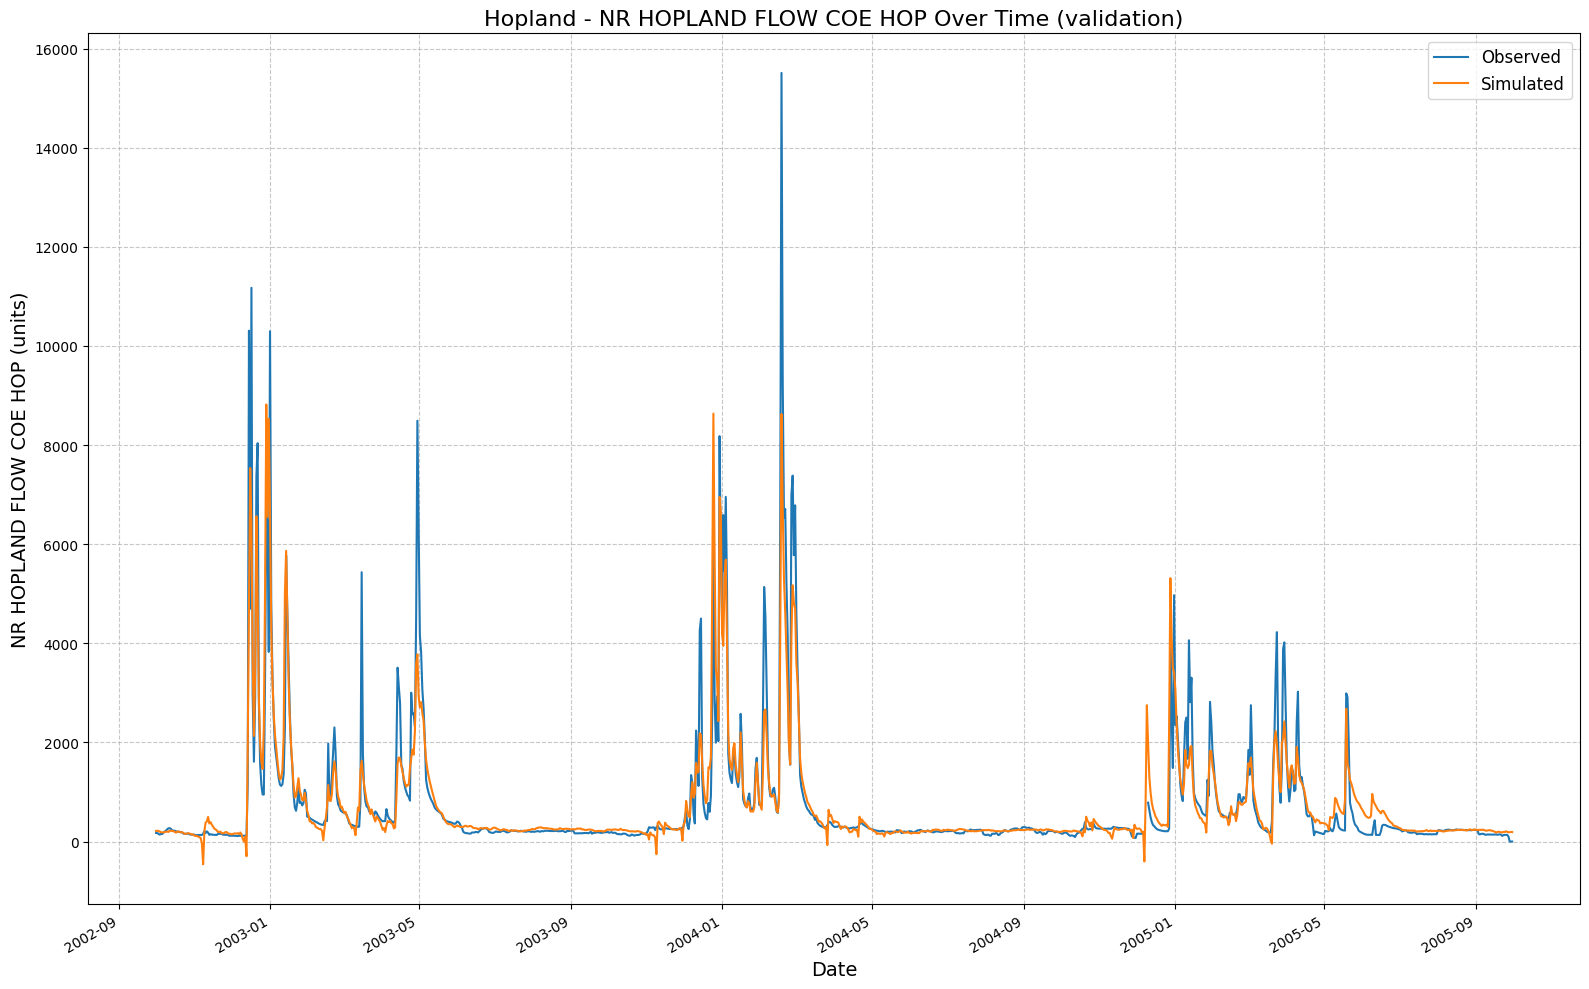

[INFO] CSV output saved at: c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164920\results_output_validation.csv


c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


In [22]:
if not skip_best_model_train:
    lstmNoPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=False,
        gpu=0
    )
    lstmNoPhysicsValBest.train()
    no_physics_val_csv, no_physics_val_metrics = lstmNoPhysicsValBest.results()
    no_physics_val_metrics

2025-03-13 16:49:28,599: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164928\output.log initialized.
2025-03-13 16:49:28,600: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164928
2025-03-13 16:49:28,600: ### Run configurations for testing_run
2025-03-13 16:49:28,601: experiment_name: testing_run
2025-03-13 16:49:28,601: train_basin_file: hopland
2025-03-13 16:49:28,602: validation_basin_file: hopland
2025-03-13 16:49:28,602: test_basin_file: hopland
2025-03-13 16:49:28,603: train_start_date: 1994-10-01 00:00:00
2025-03-13 16:49:28,604: train_end_date: 2002-09-30 00:00:00
2025-03-13 16:49:28,604: validation_start_date: 2002-10-01 00:00:00
2025-03-13 16:49:28,604: validation_end_date: 2005-09-30 00:00:00
2025-03-13 16:49:28,605: test_start_date: 2005-10-01 00:00:00
2025-03-13 16:49:28,605: test_end_date: 2009-09-29 00:00:00
2025-03-13 16:

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]
2025-03-13 16:49:58,218: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164928\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:49:58,219: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164928\validation\model_epoch032\validation_results.p
got predictions


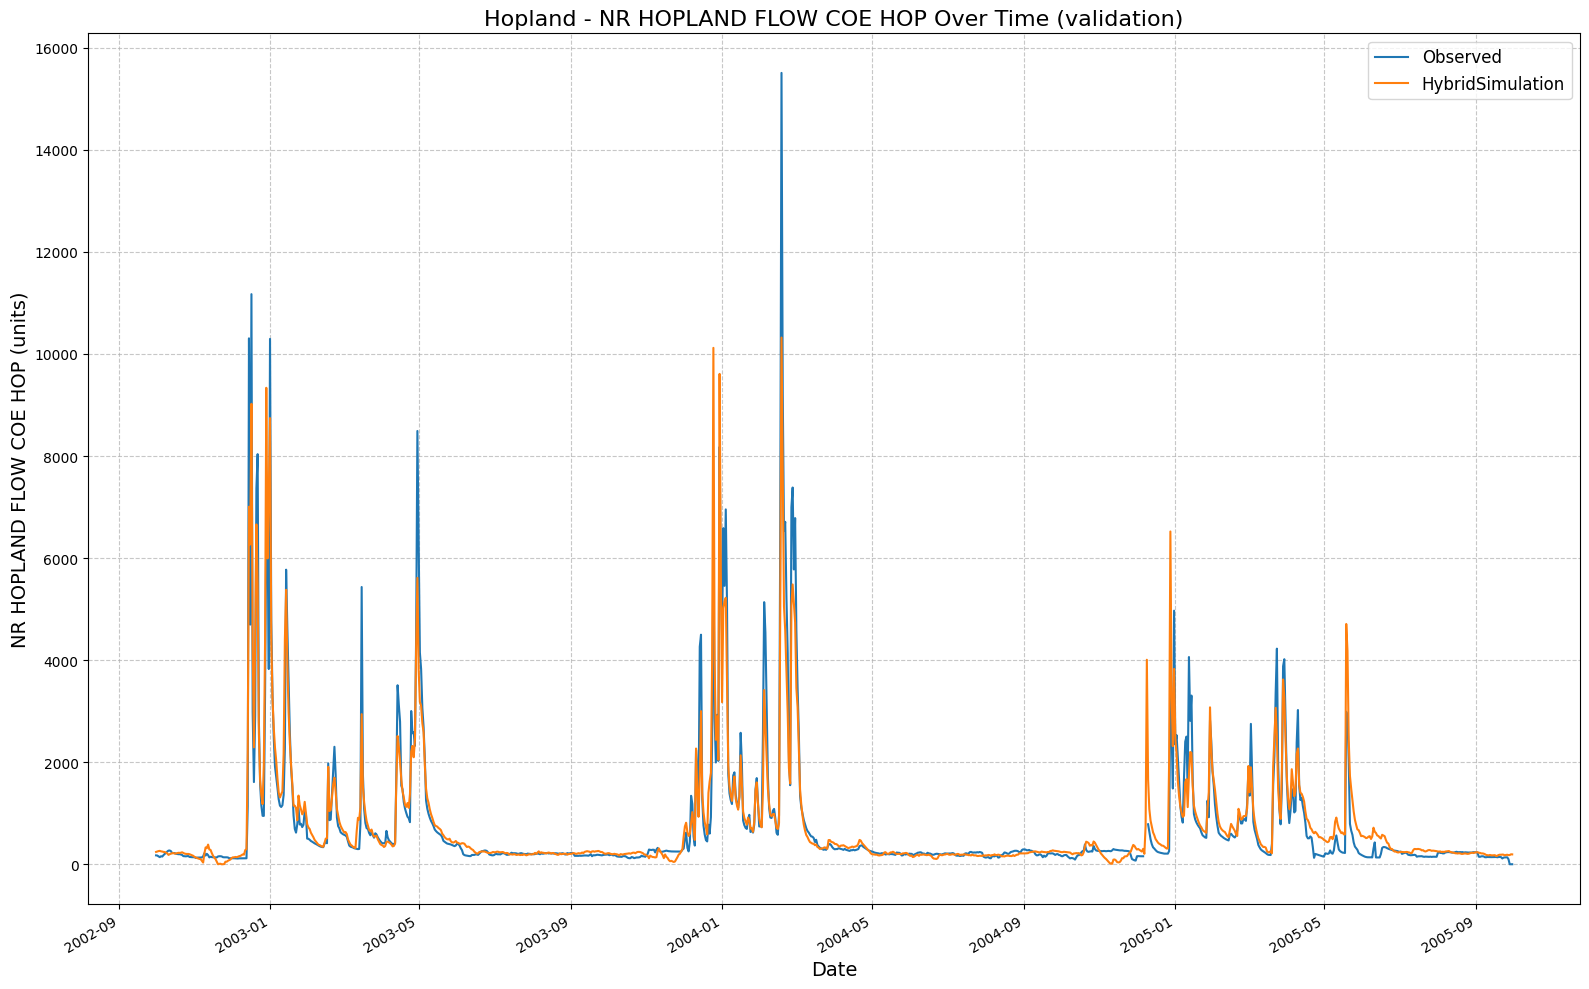

[INFO] CSV output saved at: c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_164928\results_output_validation.csv


c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


In [23]:
if not skip_best_model_train:
    lstmPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=False,
        gpu=-1
    )
    lstmPhysicsValBest.train()
    physics_val_csv, physics_val_metrics = lstmPhysicsValBest.results()
    physics_val_metrics

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\data

[INFO] Wrote metrics CSV: CV_hopland_daily_val_metrics.csv
[INFO] Saved figure: CV_hopland_daily_val_model_comparison.png


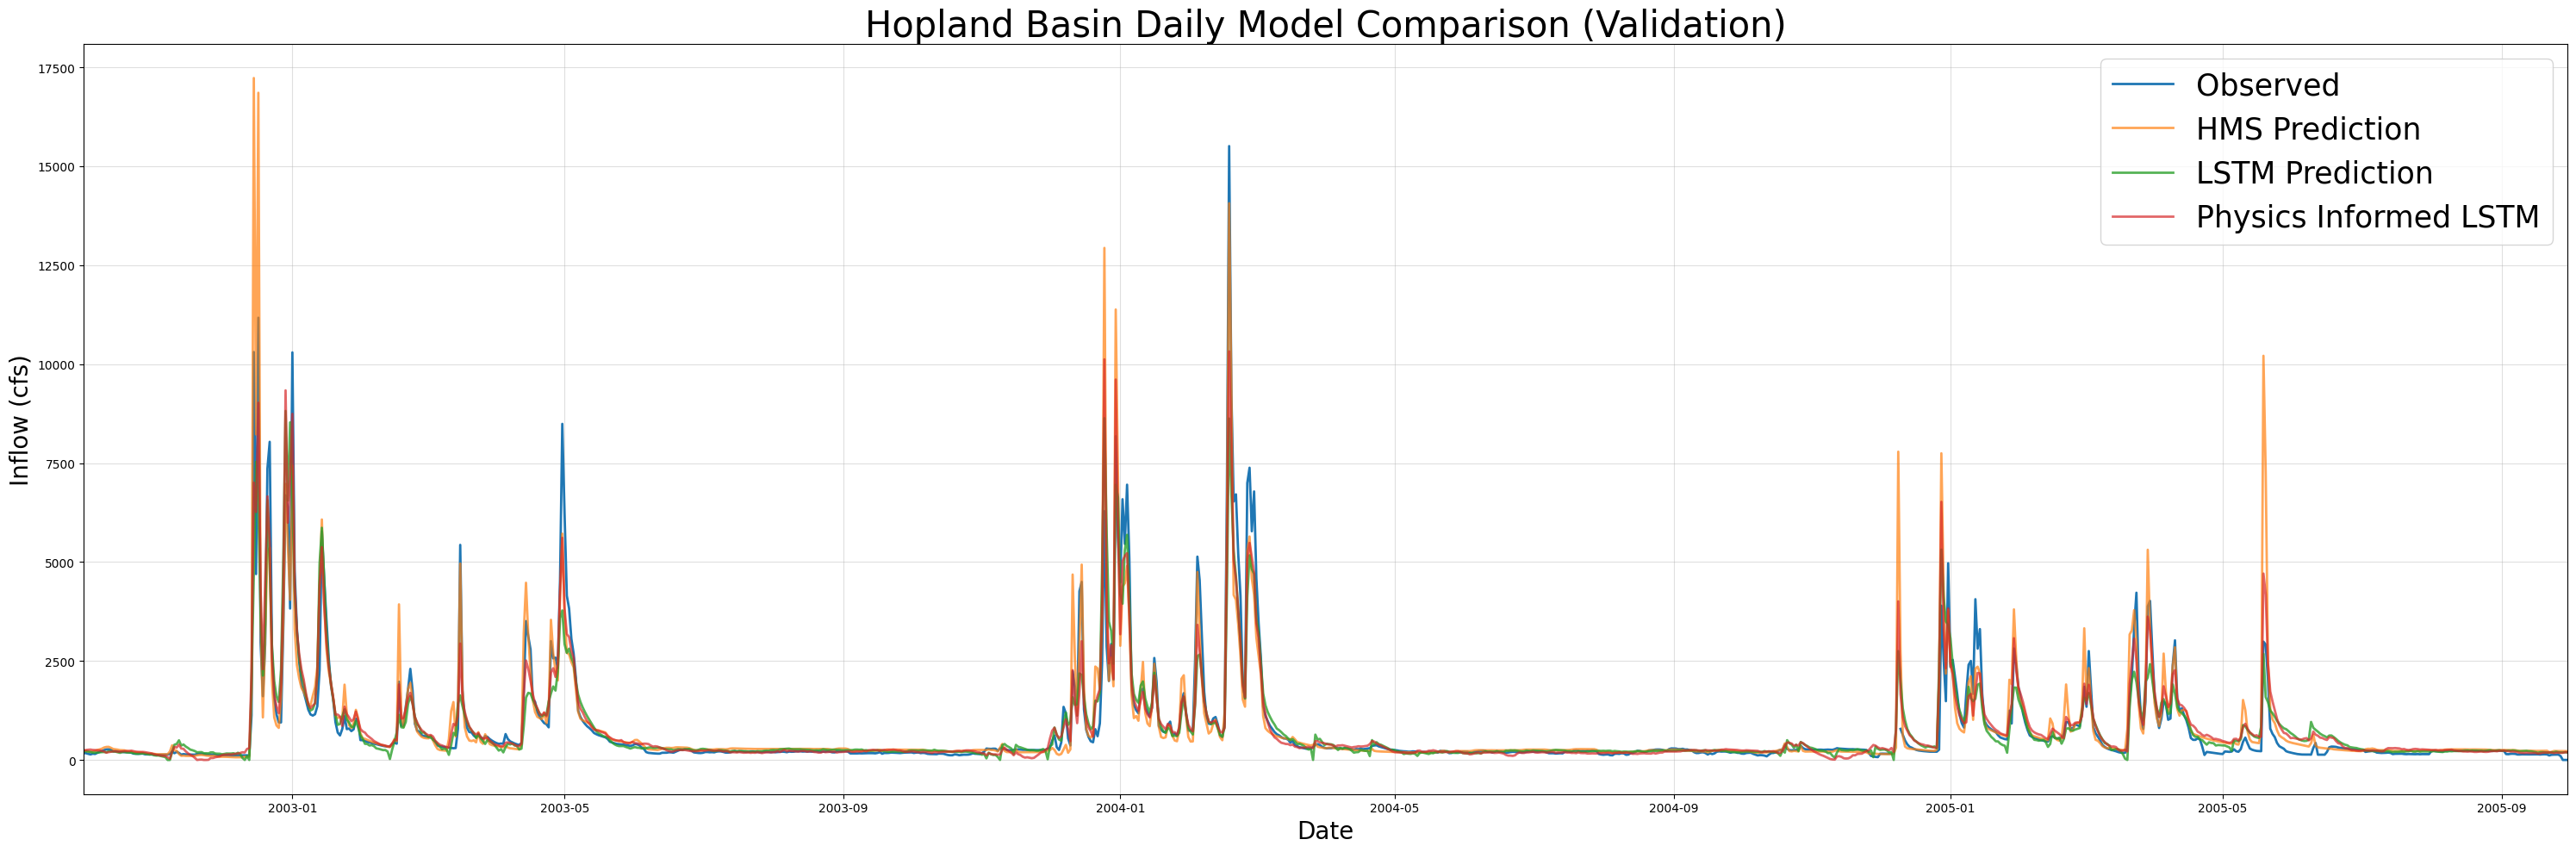

In [24]:
if not skip_best_model_train:
    combinedPlot(
        lstm_results=no_physics_val_csv,
        lstmPhysics_results=physics_val_csv,
        HMS_results=path_to_physics_data,
        title="Hopland Basin Daily Model Comparison (Validation)",
        fName="CV_hopland_daily_val_metrics.csv",
        plot_filename="CV_hopland_daily_val_model_comparison.png",
        timeseries_filename ="CV_hopland_daily_val_combined_ts.csv"
    )
else:
    combined_df = pd.read_csv("CV_hopland_daily_val_combined_ts.csv")
    combinedPlotFromDf(combined_df, title="Hopland Basin Daily Model Comparison (Validation)", fName="CV_hopland_daily_val_metrics.csv")

In [25]:
if not skip_best_model_train:
    fancyCombinedPlot(
        lstm_results=no_physics_val_csv,
        lstmPhysics_results=physics_val_csv,
        HMS_results=path_to_physics_data,
        title='Hopland Basin Daily Model Comparison (Validation)',
        fName="CV_hopland_daily_val_metrics.csv", 
        timeseries_filename ="CV_hopland_daily_val_combined_ts.csv"
    )
else:
    fancyCombinedPlotFromDf(combined_df, title="Hopland Basin Daily Model Comparison (Validation)", fName="CV_hopland_daily_val_metrics.csv")

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\data

[INFO] Wrote metrics CSV: CV_hopland_daily_val_metrics.csv


In [26]:
if skip_best_model_train:
    val_metrics = pd.read_csv("CV_hopland_daily_val_metrics.csv", index_col=0)
    print(val_metrics)

# Re-run testing with the best hyperparameters

2025-03-13 16:50:02,704: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_165002\output.log initialized.
2025-03-13 16:50:02,705: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_165002
2025-03-13 16:50:02,706: ### Run configurations for testing_run
2025-03-13 16:50:02,706: experiment_name: testing_run
2025-03-13 16:50:02,707: train_basin_file: hopland
2025-03-13 16:50:02,707: validation_basin_file: hopland
2025-03-13 16:50:02,708: test_basin_file: hopland
2025-03-13 16:50:02,708: train_start_date: 1994-10-01 00:00:00
2025-03-13 16:50:02,708: train_end_date: 2005-09-30 00:00:00
2025-03-13 16:50:02,709: validation_start_date: 2002-10-01 00:00:00
2025-03-13 16:50:02,709: validation_end_date: 2005-09-30 00:00:00
2025-03-13 16:50:02,710: test_start_date: 2005-10-01 00:00:00
2025-03-13 16:50:02,710: test_end_date: 2009-09-29 00:00:00
2025-03-13 16:

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this ex

# Validation: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
2025-03-13 16:50:11,965: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_165002\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:50:11,966: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_165002\validation\model_epoch032\validation_results.p
2025-03-13 16:50:11,977: Using the model weights from c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_165002\model_epoch032.pt


c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this ex

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
2025-03-13 16:50:12,224: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_165002\test\model_epoch032\test_metrics.csv
2025-03-13 16:50:12,226: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_165002\test\model_epoch032\test_results.p
got predictions


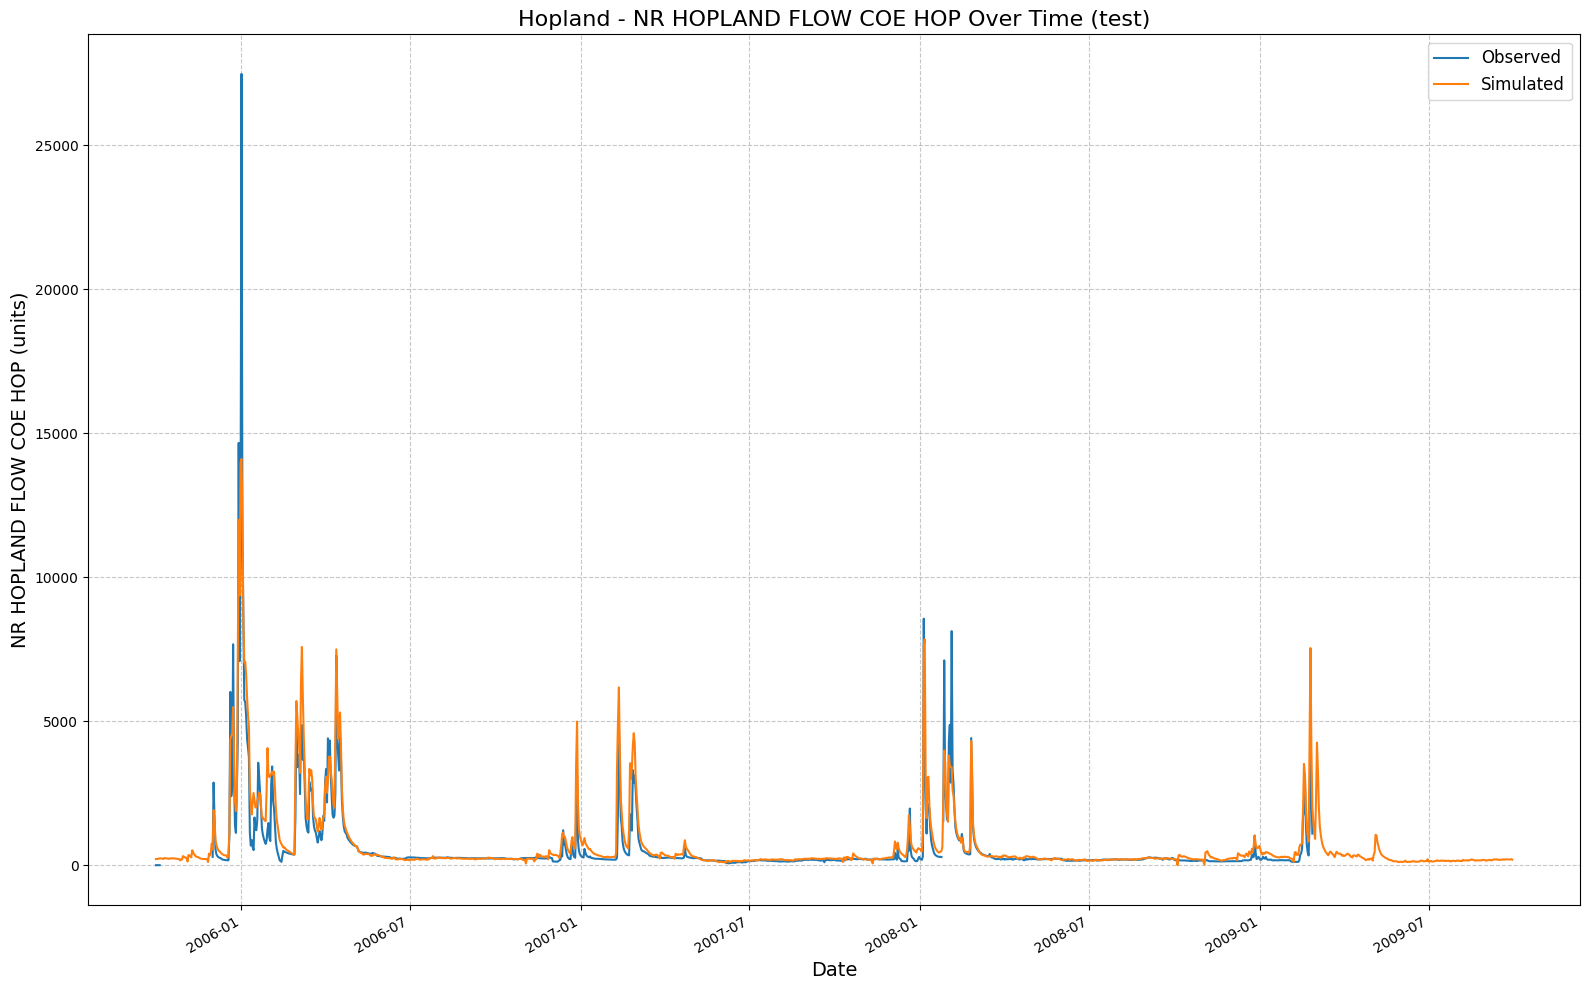

[INFO] CSV output saved at: c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_165002\results_output_test.csv


c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\metrics.py:526: RuntimeWarning:

invalid value encountered in log

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.



In [27]:
if not skip_best_model_train:
    hoplandNoPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,  
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=True, 
        gpu=0
    )
    
    hoplandNoPhysicsExtBest.train()
    no_physics_test_csv, no_physics_test_metrics = hoplandNoPhysicsExtBest.results('test')
    no_physics_test_metrics

2025-03-13 16:50:12,545: Logging to c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_165012\output.log initialized.
2025-03-13 16:50:12,546: ### Folder structure created at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_165012
2025-03-13 16:50:12,547: ### Run configurations for testing_run
2025-03-13 16:50:12,547: experiment_name: testing_run
2025-03-13 16:50:12,548: train_basin_file: hopland
2025-03-13 16:50:12,549: validation_basin_file: hopland
2025-03-13 16:50:12,550: test_basin_file: hopland
2025-03-13 16:50:12,551: train_start_date: 1994-10-01 00:00:00
2025-03-13 16:50:12,551: train_end_date: 2005-09-30 00:00:00
2025-03-13 16:50:12,552: validation_start_date: 2002-10-01 00:00:00
2025-03-13 16:50:12,553: validation_end_date: 2005-09-30 00:00:00
2025-03-13 16:50:12,553: test_start_date: 2005-10-01 00:00:00
2025-03-13 16:50:12,554: test_end_date: 2009-09-29 00:00:00
2025-03-13 16:

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this ex

# Validation: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]
2025-03-13 16:50:23,005: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_165012\validation\model_epoch032\validation_metrics.csv
2025-03-13 16:50:23,007: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_165012\validation\model_epoch032\validation_results.p
2025-03-13 16:50:23,021: Using the model weights from c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_165012\model_epoch032.pt


c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\tester.py:133: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this ex

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
2025-03-13 16:50:23,438: Stored metrics at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_165012\test\model_epoch032\test_metrics.csv
2025-03-13 16:50:23,439: Stored results at c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_165012\test\model_epoch032\test_results.p
got predictions


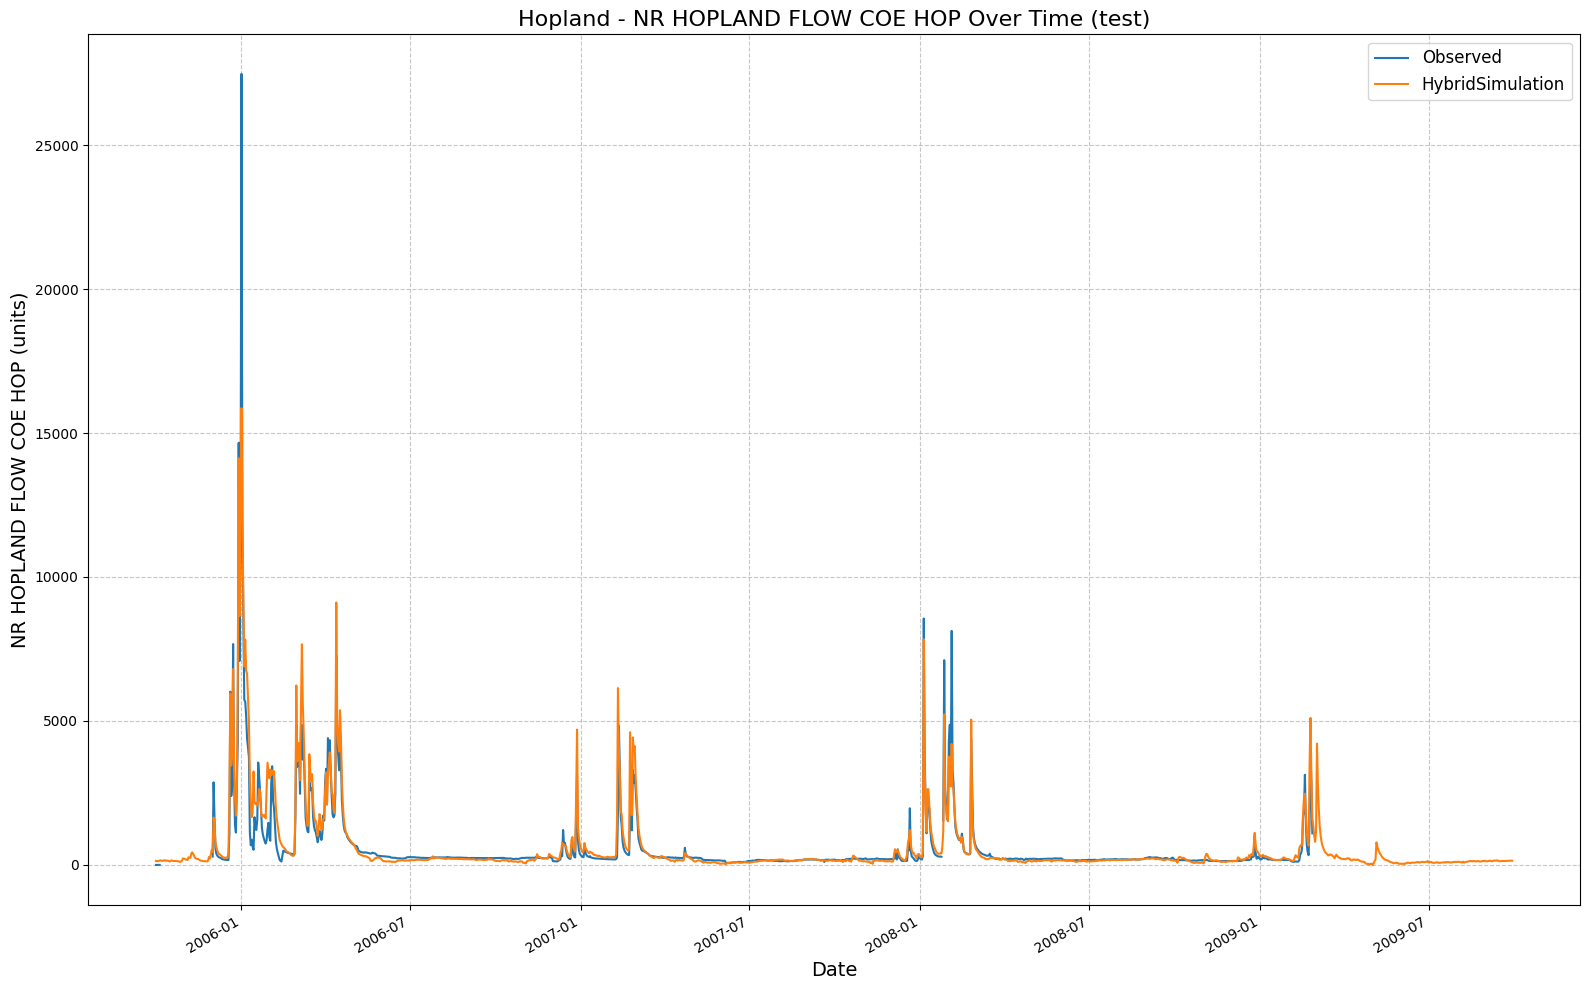

[INFO] CSV output saved at: c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\runs\testing_run_1303_165012\results_output_test.csv


c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\metrics.py:526: RuntimeWarning:

invalid value encountered in log

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.



In [28]:
if not skip_best_model_train:
    hoplandPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,  
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=True,
        gpu=0
    )
    
    hoplandPhysicsExtBest.train()
    physics_test_csv, physics_test_metrics = hoplandPhysicsExtBest.results('test')
    physics_test_metrics

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\metrics.py:526: RuntimeWarning:

invalid value encountered in log

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\metrics.py:526: RuntimeWarning:

invalid value encountered in log

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-L

[INFO] Wrote metrics CSV: CV_hopland_daily_test_metrics.csv
[INFO] Saved figure: CV_hopland_daily_test_model_comparison.png


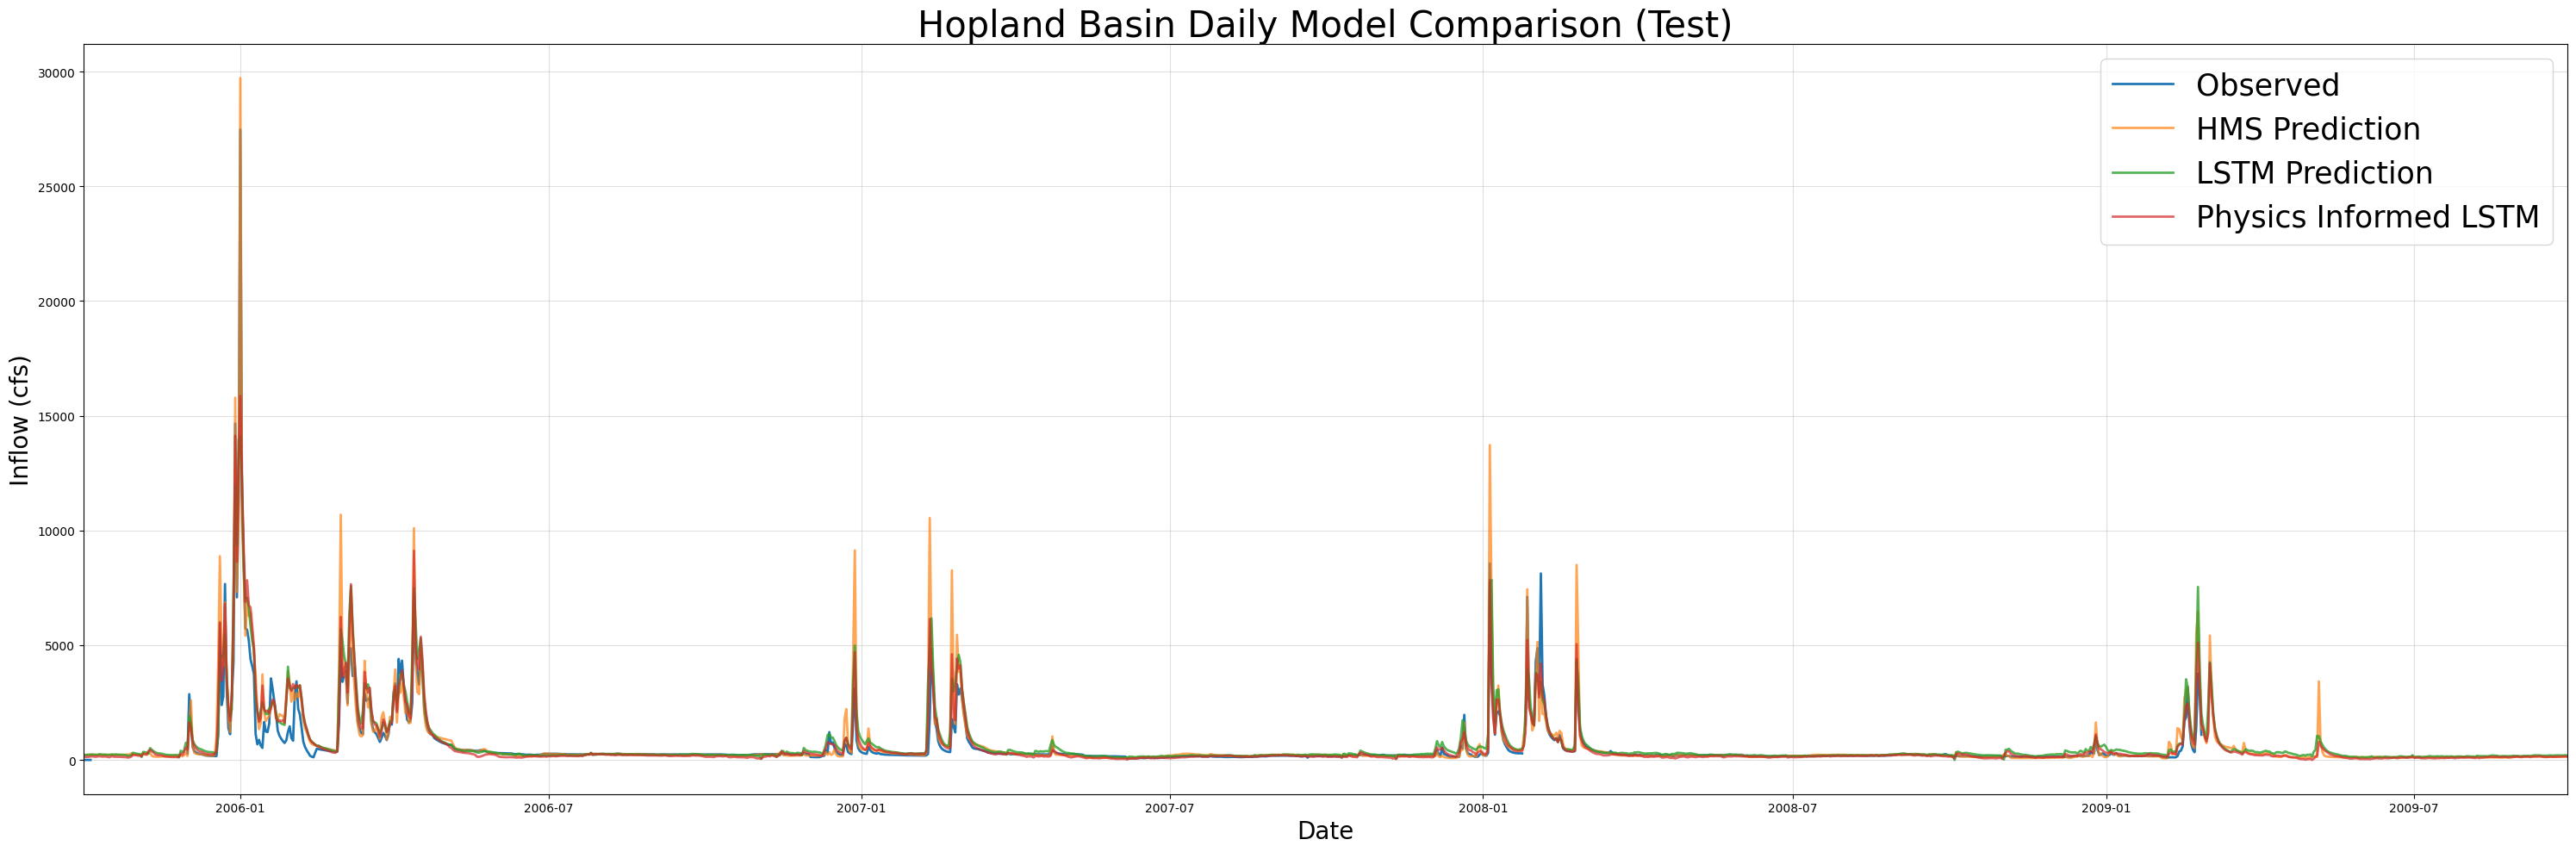

In [29]:
if not skip_best_model_train:
    combinedPlot(
        lstm_results=no_physics_test_csv,
        lstmPhysics_results=physics_test_csv,
        HMS_results=path_to_physics_data,
        title="Hopland Basin Daily Model Comparison (Test)",
        fName="CV_hopland_daily_test_metrics.csv",
        plot_filename="CV_hopland_daily_test_model_comparison.png", 
        timeseries_filename ="CV_hopland_daily_test_combined_ts.csv"
    )
else:
    combined_df = pd.read_csv("CV_hopland_daily_test_combined_ts.csv")
    combinedPlotFromDf(combined_df, title="Hopland Basin Daily Model Comparison (Test)", fName="CV_hopland_daily_test_metrics.csv")

In [30]:
if not skip_best_model_train:
    fancyCombinedPlot(lstm_results=no_physics_test_csv, lstmPhysics_results= physics_test_csv, HMS_results=path_to_physics_data, title='Hopland Basin Daily Model Comparison', fName = "CV_hopland_daily_test_metrics.csv", timeseries_filename ="CV_hopland_daily_test_combined_ts.csv")
else:
    fancyCombinedPlotFromDf(combined_df, title="Hopland Basin Daily Model Comparison (Test)", fName="CV_hopland_daily_test_metrics.csv")

[INFO] Wrote metrics CSV: CV_hopland_daily_test_metrics.csv


c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\metrics.py:526: RuntimeWarning:

invalid value encountered in log

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\evaluation\metrics.py:526: RuntimeWarning:

invalid value encountered in log

c:\Users\arman\ucb-usace-lstm\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-L

In [31]:
if skip_best_model_train:
    test_metrics = pd.read_csv("CV_hopland_daily_test_metrics.csv", index_col=0)
    print(test_metrics)